# Project by Lennart Wallentin, lennartwallentin@gmail.com

Churn is a big part for every organization that offers an online product or service and also within the hospitality sector. Being able to forecast churn and also explain what causes churn are an immense help for those organizations and their decision makers. The combination of a lot of data and sophisticated mathematical models makes it possible to forecast churn and also explain what causes churn, and that’s what my project is all about. I’m going to build a model that predicts if a person is going to cancel a hotel booking or not and try in an interpretable manner to describe the cause of the individual prediction.

The forecasting part consists of training an XGBoost classifier, tuning its hyperparameters through a process called Bayesian optimization and evaluating the classifier by a handful of evaluation metrics. 

A good insight to how a model classifies a person and what causes its prediction would be achieved if we have a method that tells us what are the minimal changes needed to flip the prediction from cancel to not cancel or vice versa. Luckily there is a method available to help us gain this insight. That method is called ‘Counterfactuals Guided by Prototypes’ and is part of the open source Alibi library. This is the method I'm going to use when trying to describe the cause of the individual prediction in an interpretable manner.

The two parts, forecasting and counterfactuals guided by prototypes, are the cornerstones of this project. But to be able to implement them data preparations are needed. This is hence the structure of this project:

(1) Data preparation

    (1.1) Data presentation
    (1.2) Handling NA and missing values
    (1.3) Check data types and outliers 
    (1.4) Correlation - Pearson and Cramer’s V 
    (1.5) Avoid unique values
    (1.6) Encoding and create train and test sets		

(2) XGBoost

    (2.1) Hyperparamter tuning - Bayesian optimization
    (2.2) Evaluate the model 

(3) Alibi

    (3.1) Counterfactuals Guided by Prototypes - in action

In each section detailed comments are written about what we want to achieve and what’s going on in the code. The code is also made reproducible by consequently setting seed = 42, shuffle = True and shuffle = False where needed. 

# 1. Data preparation

## 1.1 Data presentation 
The data is originally downloaded from the website kaggle.com and has an original data article linked to it. I'm going to use the data article as a reference to some of my data preparation decisions. The dataset contains information about hotel bookings at two hotels in Portugal and has 32 variables which include information like lead time, arrival month, cancellation or not etc. In this project the data is converted to a pandas dataframe and set to the variable name df.  

Links: 

Dataset - https://www.kaggle.com/jessemostipak/hotel-booking-demand 

Data article - https://www.sciencedirect.com/science/article/pii/S2352340918315191 

In [1]:
# import necessary packages 
import pandas as pd
import numpy as np
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_confusion_matrix, roc_curve, auc 
from bayes_opt import BayesianOptimization

from sklearn.inspection import partial_dependence, plot_partial_dependence

from alibi.explainers import CounterFactualProto
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
import tensorflow as tf
tf.get_logger().setLevel(40)
tf.compat.v1.disable_v2_behavior()

In [2]:
# import data and print the first 10 rows
df = pd.read_csv('/Users/Admin/iCloudDrive/ML/Project/datasets/hotel_bookings.csv')
df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [3]:
df.shape

(119390, 32)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Comment

Some variables contains missing values (children, country, agent and company) but that does not necessarily implies a missing value, to quote the data article a null value is defined as: 

<em>"The PMS assured no missing data exists in its database tables. However, in some categorical variables like Agent or Company, “NULL” is presented as one of the categories. This should not be considered a missing value, but rather as “not applicable”. For example, if a booking “Agent” is defined as “NULL” it means that the booking did not come from a travel agent."  </em>

In the next section, we handle the Null-values by setting the Null-values for ‘Agent’ and ‘Company’ to a more reasonable value than Null. 

## 1.1. Handling NA and missing values

In [5]:
df.isna().any()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                           True
babies                            False
meal                              False
country                            True
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                              True
company                            True


In [6]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [7]:
# a function that for each variable in the dataset checks if a variable contains a NA-value, counts number of observations with NA-values in the variable, and finally calculates the percentage of NA-values in that variable. If the data contains no NA-values then that information is printed out

def describe_isna_values(data):
    cc = 0      # column counter
    cnac = 0    # column with isna() values counter
    for i in data.columns:        
        missing = data[i].isna()
        num_missing = missing.sum()
        pct_missing = missing.mean()*100 
        cc = cc + 1
    
        if num_missing > 0:
            print(f'Column with NA-value: {i:8} {num_missing:8} missing values {pct_missing:8.3f}% of the values is NA-values')
            cnac = cnac + 1
        
        if cc == len(data.columns) and cnac == 0:
            print(f'No NA-values (checked {cc} columns out of {len(data.columns)} columns)')

In [8]:
describe_isna_values(df)

Column with NA-value: children        4 missing values    0.003% of the values is NA-values
Column with NA-value: country       488 missing values    0.409% of the values is NA-values
Column with NA-value: agent       16340 missing values   13.686% of the values is NA-values
Column with NA-value: company    112593 missing values   94.307% of the values is NA-values


### Comment
In the below code sections: The observations in ‘Agent’ and ‘Company’ with NA-values get a value of 999, it’s a value that should be interpreted as ‘Other’. 

The observations in ‘Children’ and ‘Country’ with NA-values are deleted since they are so few.

In [9]:
df.agent.value_counts(dropna=False)

9.0      31961
NaN      16340
240.0    13922
1.0       7191
14.0      3640
         ...  
408.0        1
304.0        1
431.0        1
90.0         1
54.0         1
Name: agent, Length: 334, dtype: int64

In [10]:
# verify that 999 is not a value in use
sorted(df.agent.unique())[-1]

535.0

In [11]:
# NaN is replaced with 999
df.agent = df.agent.fillna(999)
df.agent.value_counts()

9.0      31961
999.0    16340
240.0    13922
1.0       7191
14.0      3640
         ...  
289.0        1
304.0        1
337.0        1
446.0        1
431.0        1
Name: agent, Length: 334, dtype: int64

In [12]:
sorted(df.agent.unique())[-1]

999.0

In [13]:
df.company.value_counts(dropna=False)

NaN      112593
40.0        927
223.0       784
67.0        267
45.0        250
          ...  
253.0         1
425.0         1
11.0          1
104.0         1
501.0         1
Name: company, Length: 353, dtype: int64

In [14]:
# verify that 999 is not a value in use
sorted(df.company.unique())[-1]

543.0

In [15]:
# NaN is replaced with 999
df.company = df.company.fillna(999)
df.company.value_counts()

999.0    112593
40.0        927
223.0       784
67.0        267
45.0        250
          ...  
64.0          1
415.0         1
479.0         1
253.0         1
412.0         1
Name: company, Length: 353, dtype: int64

## Alert
When checking that everything went well replacing NaN with 999 in ‘Company’ we observe that many companies have only one observation, this is not optimal and will be handled further down the code.  

In [16]:
sorted(df.company.unique())[-1]

999.0

In [17]:
describe_isna_values(df)

Column with NA-value: children        4 missing values    0.003% of the values is NA-values
Column with NA-value: country       488 missing values    0.409% of the values is NA-values


In [18]:
# drop rows with NA-values (children and country)
df.dropna(inplace=True)

In [19]:
# verify that the dataframe no longer have any missing values 
describe_isna_values(df)
df.isna().any().sum()

No NA-values (checked 32 columns out of 32 columns)


0

## 1.2. Check data types and outliers  

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118898 non-null  object 
 1   is_canceled                     118898 non-null  int64  
 2   lead_time                       118898 non-null  int64  
 3   arrival_date_year               118898 non-null  int64  
 4   arrival_date_month              118898 non-null  object 
 5   arrival_date_week_number        118898 non-null  int64  
 6   arrival_date_day_of_month       118898 non-null  int64  
 7   stays_in_weekend_nights         118898 non-null  int64  
 8   stays_in_week_nights            118898 non-null  int64  
 9   adults                          118898 non-null  int64  
 10  children                        118898 non-null  float64
 11  babies                          118898 non-null  int64  
 12  meal            

### Comment
The data types (categorical or numerical) are listed in the data article. I compare and adjust the Dtypes (data types) in df to match their description in the data article.   

In [21]:
numeric_is_categorical = {'agent','company','is_canceled','is_repeated_guest'}
df.loc[:, numeric_is_categorical]

,is_repeated_guest,company,agent,is_canceled
0,0,999.0,999.0,0
1,0,999.0,999.0,0
2,0,999.0,999.0,0
3,0,999.0,304.0,0
4,0,999.0,240.0,0
...,...,...,...,...
119385,0,999.0,394.0,0
119386,0,999.0,9.0,0
119387,0,999.0,9.0,0
119388,0,999.0,89.0,0


In [22]:
numeric_df = df.select_dtypes(exclude='object')
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118898 non-null  int64  
 1   lead_time                       118898 non-null  int64  
 2   arrival_date_year               118898 non-null  int64  
 3   arrival_date_week_number        118898 non-null  int64  
 4   arrival_date_day_of_month       118898 non-null  int64  
 5   stays_in_weekend_nights         118898 non-null  int64  
 6   stays_in_week_nights            118898 non-null  int64  
 7   adults                          118898 non-null  int64  
 8   children                        118898 non-null  float64
 9   babies                          118898 non-null  int64  
 10  is_repeated_guest               118898 non-null  int64  
 11  previous_cancellations          118898 non-null  int64  
 12  previous_booking

In [24]:
# cast variable 'children' from float to integer
df.children = df.children.astype('int64')
numeric_df.children = numeric_df.children.astype('int64')

In [25]:
numeric_df.shape

(118898, 20)

In [26]:
numeric_df.loc[:,numeric_is_categorical] 

,is_repeated_guest,company,agent,is_canceled
0,0,999.0,999.0,0
1,0,999.0,999.0,0
2,0,999.0,999.0,0
3,0,999.0,304.0,0
4,0,999.0,240.0,0
...,...,...,...,...
119385,0,999.0,394.0,0
119386,0,999.0,9.0,0
119387,0,999.0,9.0,0
119388,0,999.0,89.0,0


In [27]:
# drop categorical variables from the numeric_df
numeric_df = numeric_df.drop(numeric_is_categorical,axis=1)

In [28]:
numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       118898 non-null  int64  
 1   arrival_date_year               118898 non-null  int64  
 2   arrival_date_week_number        118898 non-null  int64  
 3   arrival_date_day_of_month       118898 non-null  int64  
 4   stays_in_weekend_nights         118898 non-null  int64  
 5   stays_in_week_nights            118898 non-null  int64  
 6   adults                          118898 non-null  int64  
 7   children                        118898 non-null  int64  
 8   babies                          118898 non-null  int64  
 9   previous_cancellations          118898 non-null  int64  
 10  previous_bookings_not_canceled  118898 non-null  int64  
 11  booking_changes                 118898 non-null  int64  
 12  days_in_waiting_

In [29]:
numeric_df.describe()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000
mean,104.311435,2016.157656,27.166555,15.800880,0.928897,2.502145,1.858391,0.104207,0.007948,0.087142,0.131634,0.221181,2.330754,102.003243,0.061885,0.571683
std,106.903309,0.707459,13.589971,8.780324,0.996216,1.900168,0.578576,0.399172,0.097380,0.845869,1.484672,0.652785,17.630452,50.485862,0.244172,0.792678
min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000
50%,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


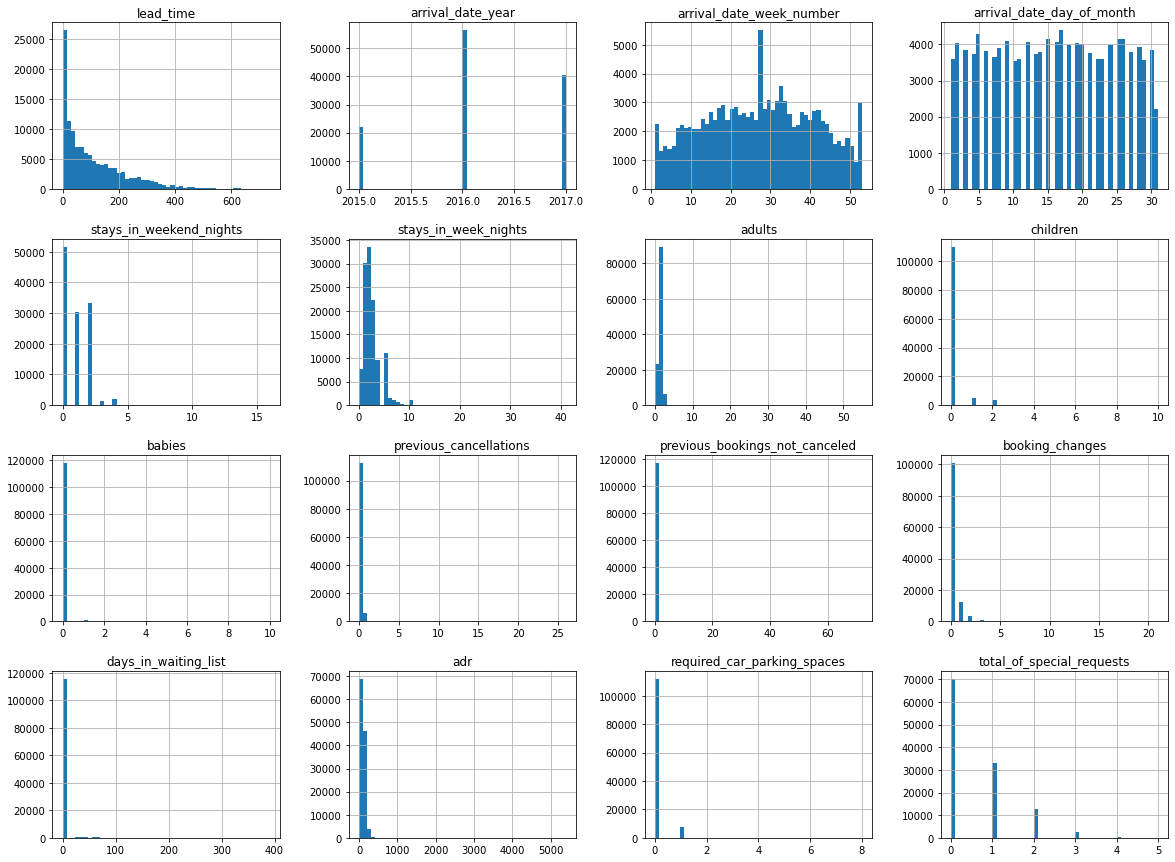

In [30]:
numeric_df.hist(bins=50, figsize=(20,15))
plt.show()

### Comment
We see in ‘adr’ (Average Daily Rate) that it contains a min value that is negative. That shouldn't be possible, we don't want to give out free rooms… Thus check how many observations in df have a negative value and specifically how many observations in ‘adr’ have a negative average daily rate and delete those rows. 

In [31]:
# use numeric_df because df includes categorical variables 
(numeric_df < 0).sum(axis=0)

lead_time                         0
arrival_date_year                 0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               1
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

In [32]:
# delete the row where adr < 0
df = df.drop(df.adr.loc[df.adr < 0].index, axis=0)
numeric_df = numeric_df.drop(numeric_df.adr.loc[numeric_df.adr < 0].index, axis=0)

In [33]:
# reset index on the dataframes
df = df.reset_index(drop=True)
numeric_df = numeric_df.reset_index(drop=True)

## 1.3. Correlation - Pearson and Cramer’s V
Show the correlation between numerical variables (Pearson correlation) and then the correlation between categorical variables (Cramér's V).

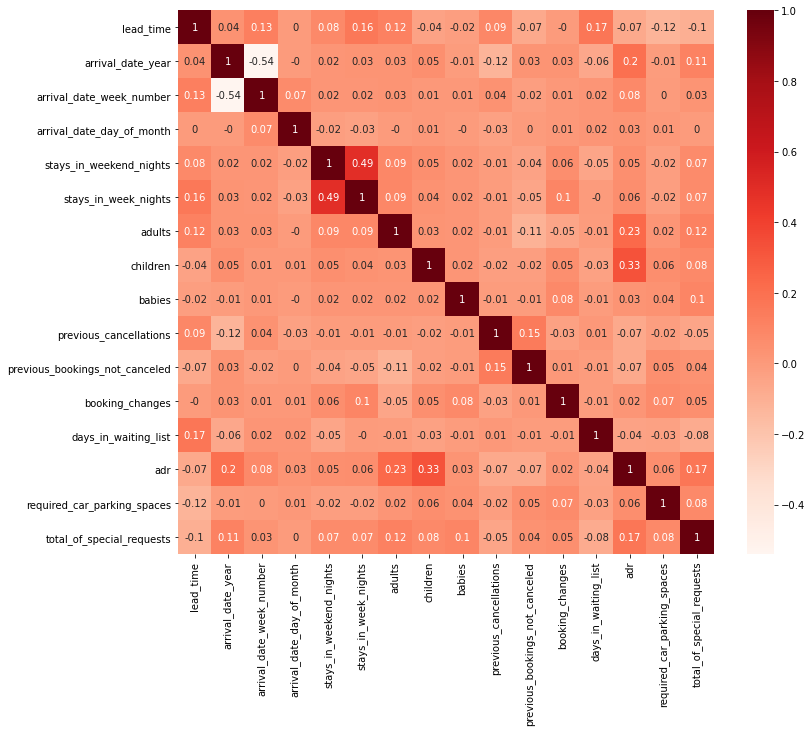

In [34]:
plt.figure(figsize=(12,10))
numeric_corr = round(numeric_df.corr(),2)
sns.heatmap(numeric_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [35]:
# to ease the sorting return absolute value from numeric_corr
numeric_corr_abs = numeric_corr.abs().unstack()
# choose < 1 to avoid printing "noise" from the diagonal line with 1's
numeric_corr_abs_sort = numeric_corr_abs[(numeric_corr_abs < 1)].sort_values(ascending = False)
numeric_corr_abs_sort

arrival_date_year          arrival_date_week_number       0.54
arrival_date_week_number   arrival_date_year              0.54
stays_in_weekend_nights    stays_in_week_nights           0.49
stays_in_week_nights       stays_in_weekend_nights        0.49
children                   adr                            0.33
                                                          ... 
days_in_waiting_list       stays_in_week_nights           0.00
arrival_date_day_of_month  lead_time                      0.00
                           babies                         0.00
stays_in_week_nights       days_in_waiting_list           0.00
arrival_date_week_number   required_car_parking_spaces    0.00
Length: 240, dtype: float64

### Comment - Numerical correlation
The correlation between the numerical variables is not strong enough for any variable to be discarded 

In [36]:
# create a categorical dataframe
categorical_df = df.select_dtypes(include='object')
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118897 entries, 0 to 118896
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   hotel                    118897 non-null  object
 1   arrival_date_month       118897 non-null  object
 2   meal                     118897 non-null  object
 3   country                  118897 non-null  object
 4   market_segment           118897 non-null  object
 5   distribution_channel     118897 non-null  object
 6   reserved_room_type       118897 non-null  object
 7   assigned_room_type       118897 non-null  object
 8   deposit_type             118897 non-null  object
 9   customer_type            118897 non-null  object
 10  reservation_status       118897 non-null  object
 11  reservation_status_date  118897 non-null  object
dtypes: object(12)
memory usage: 10.9+ MB


In [37]:
# concatenate categorical_df to include all categorical variables, reset the index and cast the variables to object
categorical_df = pd.concat([categorical_df, df.loc[:,numeric_is_categorical]], axis=1)
categorical_df = categorical_df.reset_index(drop=True)
categorical_df = categorical_df.astype(object)

In [38]:
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118897 entries, 0 to 118896
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   hotel                    118897 non-null  object
 1   arrival_date_month       118897 non-null  object
 2   meal                     118897 non-null  object
 3   country                  118897 non-null  object
 4   market_segment           118897 non-null  object
 5   distribution_channel     118897 non-null  object
 6   reserved_room_type       118897 non-null  object
 7   assigned_room_type       118897 non-null  object
 8   deposit_type             118897 non-null  object
 9   customer_type            118897 non-null  object
 10  reservation_status       118897 non-null  object
 11  reservation_status_date  118897 non-null  object
 12  is_repeated_guest        118897 non-null  object
 13  company                  118897 non-null  object
 14  agent               

In [39]:
# label encode the categorical variables 
categorical_enc_corr = preprocessing.LabelEncoder()
categorical_corr_encoded = pd.DataFrame()

for i in categorical_df.columns :
  categorical_corr_encoded[i]=categorical_enc_corr.fit_transform(categorical_df[i].astype(str))

In [40]:
# a function that calculates the Cramer's V between the categorical variables

def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # crosstab/contingency table, displays the frequency distribution of the variables
    chi2 = chi2_contingency(crosstab)[0] # chi-square test of independence of the variables 
    n = np.sum(crosstab)
    phi2 = chi2 / n # calculate the phi coefficient
    r, k = crosstab.shape # number of rows and columns
    
    # bias correction, to avoid overestimate the strength of association
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) 
    rcorr = r - ((r-1)**2)/(n-1) 
    kcorr = k - ((k-1)**2)/(n-1) 

    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

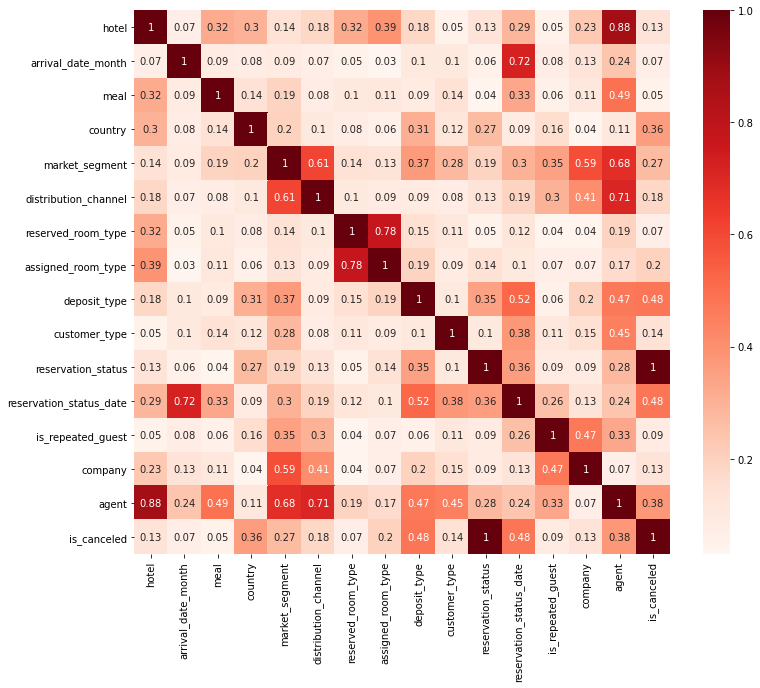

In [41]:
rows = [] # create empty list

for var1 in categorical_corr_encoded:
  col = [] 
  for var2 in categorical_corr_encoded:
    cramers = cramers_V(categorical_corr_encoded[var1], categorical_corr_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # append rounded value (two decimal places)  
  rows.append(col) 

# create the correlation matrix 
categorical_corr = pd.DataFrame(np.array(rows), columns = categorical_corr_encoded.columns, index = categorical_corr_encoded.columns)
plt.figure(figsize=(12,10))
sns.heatmap(categorical_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [42]:
# return absolute value from categorical_corr 
categorical_corr_abs = categorical_corr.abs().unstack()
# choose < 1 to avoid printing "noise" from the diagonal line with 1's
categorical_corr_abs_sort = categorical_corr_abs[np.logical_and(categorical_corr_abs < 1, categorical_corr_abs >= 0.7)].sort_values(ascending = False)
print(categorical_corr_abs_sort)

hotel                    agent                      0.88
agent                    hotel                      0.88
reserved_room_type       assigned_room_type         0.78
assigned_room_type       reserved_room_type         0.78
arrival_date_month       reservation_status_date    0.72
reservation_status_date  arrival_date_month         0.72
distribution_channel     agent                      0.71
agent                    distribution_channel       0.71
dtype: float64


In [43]:
# check which variables 'reservation_status' have a 1 correlation with
categorical_corr_abs[categorical_corr_abs == 1].loc['reservation_status']

reservation_status    1.0
is_canceled           1.0
dtype: float64

### Comment - Categorical correlation
If two variables have a correlation with each other that is above 0.7, delete one of the two variables because they are considered to be very similar. 

In [44]:
categorical_corr_drop = {'reservation_status', 'agent', 'reservation_status_date', 'assigned_room_type'} 

In [45]:
categorical_df = categorical_df.drop(categorical_corr_drop, axis=1)
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118897 entries, 0 to 118896
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   hotel                 118897 non-null  object
 1   arrival_date_month    118897 non-null  object
 2   meal                  118897 non-null  object
 3   country               118897 non-null  object
 4   market_segment        118897 non-null  object
 5   distribution_channel  118897 non-null  object
 6   reserved_room_type    118897 non-null  object
 7   deposit_type          118897 non-null  object
 8   customer_type         118897 non-null  object
 9   is_repeated_guest     118897 non-null  object
 10  company               118897 non-null  object
 11  is_canceled           118897 non-null  object
dtypes: object(12)
memory usage: 10.9+ MB


In [46]:
# in df, drop the selected variables 
df = df.drop(categorical_corr_drop, axis=1)
# cast variables to their correct Dtype (exclude casting 'is_canceled' beacuse it's the target variable)
df.company = df.company.astype(object)
df.is_repeated_guest = df.is_repeated_guest.astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118897 entries, 0 to 118896
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118897 non-null  object 
 1   is_canceled                     118897 non-null  int64  
 2   lead_time                       118897 non-null  int64  
 3   arrival_date_year               118897 non-null  int64  
 4   arrival_date_month              118897 non-null  object 
 5   arrival_date_week_number        118897 non-null  int64  
 6   arrival_date_day_of_month       118897 non-null  int64  
 7   stays_in_weekend_nights         118897 non-null  int64  
 8   stays_in_week_nights            118897 non-null  int64  
 9   adults                          118897 non-null  int64  
 10  children                        118897 non-null  int64  
 11  babies                          118897 non-null  int64  
 12  meal            

## 1.4. Avoid unique values 
As brought up earlier it isn't optimal that some variables have only one observation when conducting tree-based learning, grouping on variables with many unique observations is done below, with the number of observations on the 50th percentile as a cut off point.  

In [47]:
# descriptive statistics on the categorical variables 
categorical_df.describe()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,is_repeated_guest,company,is_canceled
count,118897,118897,118897,118897,118897,118897,118897,118897,118897,118897,118897.0,118897
unique,2,12,5,177,7,5,10,3,4,2,350.0,2
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,No Deposit,Transient,0,999.0,0
freq,79302,13852,91862,48586,56402,97730,85600,104162,89174,115092,112274.0,74744


In [48]:
mean_categorical_unique = np.mean(categorical_df.describe().iloc[1])
median_category_unique = np.median(categorical_df.describe().iloc[1]) 
print('Variable         Unique observations')
print('--------         -------------------')
print(categorical_df.describe().iloc[1],'\n')
print(f'Mean unique observations:   {mean_categorical_unique:.3f}')
print(f'Median unique observations:  {median_category_unique:.3f}')

Variable         Unique observations
--------         -------------------
hotel                       2
arrival_date_month         12
meal                        5
country                   177
market_segment              7
distribution_channel        5
reserved_room_type         10
deposit_type                3
customer_type               4
is_repeated_guest           2
company                 350.0
is_canceled                 2
Name: unique, dtype: object 

Mean unique observations:   48.250
Median unique observations:  5.000


### Comment
I show both the mean unique observations and median unique observations because of the big difference between the two values but for coherence I choose the mean as a cut of point to avoid grouping the months 

In [49]:
# check that there not to many unique observations in some variables
for i in categorical_df.columns:
    unique_values = categorical_df[i].value_counts().count() # unique observation count for each variable
    
    # if a variable have more unique observation than the mean unique observations of categorical_df, print name of that variable and the corresponding value on the 50 percentile 
    if unique_values > categorical_df.describe().iloc[1].mean(): 
        print(f'{i}: {categorical_df[i].value_counts().describe().iloc[5]}')

country: 12.0
company: 4.0


In [50]:
# get the same result on the 50th percentile in the orginal df dataframe
print(f'country: {np.percentile(df.country.value_counts(),50)}')
print(f'company: {np.percentile(df.company.value_counts(),50)}')

country: 12.0
company: 4.0


In [51]:
# group the variables on and below the 50th percentile and rename them to 'Other'
country_bucket_values = df.country.value_counts() <= np.percentile(df.country.value_counts(),50)
country_bucket = df.country.value_counts().loc[country_bucket_values]
df.country.replace(country_bucket.index,'Other', inplace=True)

In [52]:
# group the variables on and below the 50th percentile and rename them to '998'
company_bucket_values = df.company.value_counts() <= np.percentile(df.company.value_counts(),50)
company_bucket = df.company.value_counts().loc[company_bucket_values]
df.company.replace(company_bucket.index,'998', inplace=True)

In [53]:
# delete the year column and reset index
df = df.drop('arrival_date_year', axis=1)
df = df.reset_index(drop=True)

## 1.5. Encoding and create train and test sets

In [54]:
# create the target and predict variables
y = df.is_canceled
X = df.drop('is_canceled', axis=1)

In [55]:
# one-hot encode X
X_encoded = pd.get_dummies(X)
X = X_encoded

In [56]:
# create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y, shuffle=True)

# 2. XGBoost
The pre-processing of the raw data is now completed and it’s time to use the XGBoost algorithm to model if a hotel guest is going to cancel his/her booking or not. The steps for doing that is roughly as follows: 

(1) In params set objective to ‘binary:logistic’ (target variable is binary, 0 or 1) and eval_metric to ‘logloss’. Log loss is chosen because I'm not only interested if an observation is correctly classified or not, but also how confident the model is about its predictions. E.g. If the target label of one observation is 1, a model that predicts 1 with 90% probability (lower log loss) is a better model than a model that predicts 1 with 60% confidence (higher log loss).  

(2) Cross-validation with nfold = 5 and early_stopping_rounds = 10 are used. By using cross-validation a separate validation dataset to decide the model's hyperparameters is not needed (more data efficient). When nfold is set to 5 the data is split in five partitions where the model is trained on 80 % of the data and validated on the remaining 20 %. In each training iteration we get five log loss values. The mean of these five values are then the iterations estimated log loss.
early_stopping_rounds is set to 10 to interrupt training if the log loss doesn't decrease from the current lowest estimate for ten straight iterations. This is done to help avoid overfitting.

(3) Train the model with the optimal number of boosting rounds obtained from the cross-validation. 

(4) Evaluate the model on the test dataset through a confusion matrix, accuracy and f1-score. The confusion matrix is a 2x2 table with the predicted labels on the x-axis and the true labels on the y-axis. Given a cut off limit (in this case 50% probability) the correct and incorrect predictions are grouped into four categories, true negative (tn), false positive (fp), false negative (fn) and true positive (tp). 
Accuracy is simply the percentage of the test set that is correctly classified. 
The f1-score is calculated by (2 x true positive) / ((2 x true positive) + false positive + false negative). This a score that you want to maximize.       

(5) Plot the feature importance plot. The plot is constructed by how many times a variable is used in the trees, weighted by how many observations it splits in each node. This ensures that a variable closer to the root gets a higher gain-score than a variable further from the root. 
The variable ‘deposit_type_Non Refund’ gets a suspiciously high gain score, I investigate that variable further and in the preprocessed dataset, an observation with Non Refund deposit_type also means that the observation in the is_canceled variable equals 1 over 99% of the time… In a real project I would of course talk to stakeholders to get the real reason about the deposit_type variables abnormality but on this project I instead found a discussion on Kaggle, where they conclude that it’s either visa fraud or incorrect labeling of the deposit_type values that's the cause. To keep as many observations as possible to train my model on, I decide that the cause is incorrect labeling of the deposit_type values and delete the deposit_type variables.

(6) Step 2, 3 and 4 is then carried out again.

(7) To minimize the complexity and get rid of noise the model is trained on the top 25% variables with the highest gain score obtained from the feature importance plot
   
(8) Step 2, 3 and 4 is once again carried out. 

Links:

XGBoost documentation - https://xgboost.readthedocs.io/en/latest/python/python_intro.html 

Kaggle ‘deposit_type’ discussion - https://www.kaggle.com/jessemostipak/hotel-booking-demand/discussion/131787


In [57]:
# cast the train partition to dmatrix
dmatrix_1 = xgb.DMatrix(X_train, y_train)

In [58]:
# set XGBoost parameters
params = {
    'booster' : 'gbtree', 
    'objective' : 'binary:logistic', 
    'eval_metric': 'logloss', 
    'seed': RANDOM_STATE 
    }

In [59]:
# preform a cross-validation to approximate the preferable n_estimator (optimal number of boosting rounds) for the XGBoost classifier
xgb_cv_1 = xgb.cv(dtrain=dmatrix_1, params=params, nfold=5,
                    num_boost_round=500, early_stopping_rounds=10, verbose_eval=True, seed=RANDOM_STATE, shuffle=False)

[0]	train-logloss:0.56642+0.00049	test-logloss:0.56663+0.00110
[1]	train-logloss:0.49523+0.00097	test-logloss:0.49559+0.00241
[2]	train-logloss:0.45109+0.00064	test-logloss:0.45197+0.00258
[3]	train-logloss:0.42206+0.00078	test-logloss:0.42320+0.00291
[4]	train-logloss:0.40228+0.00065	test-logloss:0.40353+0.00349
[5]	train-logloss:0.38830+0.00076	test-logloss:0.38970+0.00323
[6]	train-logloss:0.37727+0.00078	test-logloss:0.37880+0.00366
[7]	train-logloss:0.36920+0.00059	test-logloss:0.37093+0.00386
[8]	train-logloss:0.36263+0.00065	test-logloss:0.36454+0.00379
[9]	train-logloss:0.35757+0.00086	test-logloss:0.35972+0.00341
[10]	train-logloss:0.35295+0.00194	test-logloss:0.35549+0.00301
[11]	train-logloss:0.34849+0.00191	test-logloss:0.35131+0.00317
[12]	train-logloss:0.34532+0.00082	test-logloss:0.34834+0.00395
[13]	train-logloss:0.34167+0.00116	test-logloss:0.34534+0.00366
[14]	train-logloss:0.33863+0.00190	test-logloss:0.34269+0.00306
[15]	train-logloss:0.33562+0.00189	test-logloss:0.

[128]	train-logloss:0.25456+0.00206	test-logloss:0.29296+0.00405
[129]	train-logloss:0.25414+0.00227	test-logloss:0.29285+0.00402
[130]	train-logloss:0.25379+0.00232	test-logloss:0.29274+0.00413
[131]	train-logloss:0.25346+0.00229	test-logloss:0.29262+0.00409
[132]	train-logloss:0.25323+0.00220	test-logloss:0.29261+0.00408
[133]	train-logloss:0.25308+0.00231	test-logloss:0.29255+0.00402
[134]	train-logloss:0.25283+0.00225	test-logloss:0.29247+0.00410
[135]	train-logloss:0.25267+0.00215	test-logloss:0.29241+0.00412
[136]	train-logloss:0.25243+0.00203	test-logloss:0.29243+0.00411
[137]	train-logloss:0.25220+0.00192	test-logloss:0.29243+0.00414
[138]	train-logloss:0.25193+0.00179	test-logloss:0.29234+0.00418
[139]	train-logloss:0.25171+0.00175	test-logloss:0.29232+0.00419
[140]	train-logloss:0.25122+0.00185	test-logloss:0.29205+0.00407
[141]	train-logloss:0.25073+0.00189	test-logloss:0.29192+0.00399
[142]	train-logloss:0.25040+0.00173	test-logloss:0.29180+0.00406
[143]	train-logloss:0.250

[255]	train-logloss:0.21586+0.00133	test-logloss:0.28384+0.00399
[256]	train-logloss:0.21556+0.00140	test-logloss:0.28381+0.00397
[257]	train-logloss:0.21527+0.00146	test-logloss:0.28373+0.00389
[258]	train-logloss:0.21500+0.00150	test-logloss:0.28366+0.00392
[259]	train-logloss:0.21470+0.00161	test-logloss:0.28361+0.00386
[260]	train-logloss:0.21433+0.00141	test-logloss:0.28347+0.00391
[261]	train-logloss:0.21410+0.00140	test-logloss:0.28349+0.00392
[262]	train-logloss:0.21372+0.00147	test-logloss:0.28347+0.00390
[263]	train-logloss:0.21349+0.00156	test-logloss:0.28349+0.00390
[264]	train-logloss:0.21325+0.00163	test-logloss:0.28350+0.00383
[265]	train-logloss:0.21307+0.00171	test-logloss:0.28353+0.00379
[266]	train-logloss:0.21275+0.00167	test-logloss:0.28343+0.00380
[267]	train-logloss:0.21252+0.00174	test-logloss:0.28342+0.00382
[268]	train-logloss:0.21232+0.00175	test-logloss:0.28344+0.00377
[269]	train-logloss:0.21206+0.00178	test-logloss:0.28345+0.00375
[270]	train-logloss:0.211

<function matplotlib.pyplot.show(close=None, block=None)>

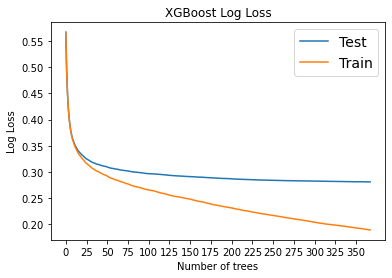

In [60]:
# plot the cross-validation log loss (early_stopping_rounds set to 10)
plt.plot(xgb_cv_1.index, xgb_cv_1['test-logloss-mean'], label='Test')
plt.plot(xgb_cv_1.index, xgb_cv_1['train-logloss-mean'], label='Train')
plt.xticks(np.arange(min(xgb_cv_1.index), max(xgb_cv_1.index)+1.1, 25)) 
plt.ylabel('Log Loss')
plt.xlabel('Number of trees')
plt.title('XGBoost Log Loss')
plt.legend(fontsize=14)
plt.show

In [61]:
# get the the best iteration (lowest test log loss) from xgb_cv_1, it will be used as the number of boosting rounds in the classifier
iter_best_1 = len(xgb_cv_1)
iter_best_1 #368 (0-indexed) 

368

In [62]:
# create a XGBClassifer instance and train the model. 
clf_xgb_1 = xgb.XGBClassifier(n_estimators=iter_best_1, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
clf_xgb_1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=368, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [63]:
# evaluate the trained model
y_pred_1 = clf_xgb_1.predict(X_test)

confu_matrix_1 = confusion_matrix(y_test, y_pred_1)
(tn_1, fp_1, fn_1, tp_1) = confusion_matrix(y_test, y_pred_1).ravel()
accuracy_1 = accuracy_score(y_test, y_pred_1)
f1_score_1 = f1_score(y_test,y_pred_1)

print(confu_matrix_1,'\n')
print('tn:',tn_1, 'fp:',fp_1, 'fn:',fn_1, 'tp:',tp_1,'\n')
print('accuracy:',accuracy_1)
print('f1 score:',f1_score_1)

[[13680  1269]
 [ 1754  7077]] 

tn: 13680 fp: 1269 fn: 1754 tp: 7077 

accuracy: 0.8728763666947015
f1 score: 0.824008849042324


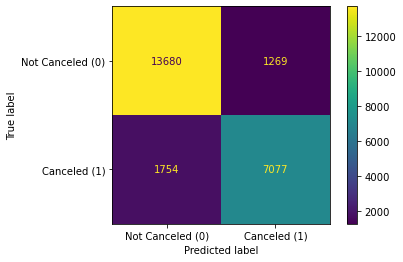

In [64]:
plot_confusion_matrix(clf_xgb_1, X_test, y_test, values_format='d', display_labels=['Not Canceled (0)','Canceled (1)'])

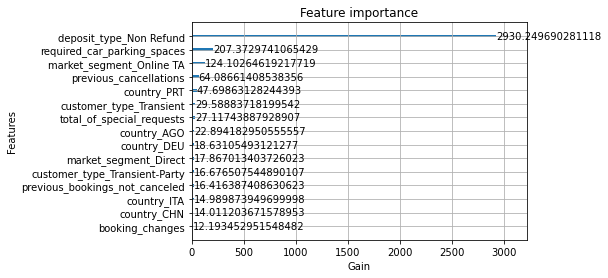

In [65]:
# importance plot showing the 15 variables with the highest gain score 
xgb.plot_importance(clf_xgb_1, max_num_features=15, importance_type = 'gain', xlabel='Gain')
plt.show()

In [66]:
print('Frequency table of Non Refund observations in the deposit type variable:')
print(df.groupby("deposit_type")["is_canceled"].value_counts().loc['Non Refund'],'\n')

print('\nPercentage of Non Refund observations in the deposit type variable:')
print(df.groupby("deposit_type")["is_canceled"].value_counts().loc['Non Refund'] / df.groupby("deposit_type")["is_canceled"].value_counts().loc['Non Refund'].sum() * 100)

Frequency table of Non Refund observations in the deposit type variable:
is_canceled
1    14480
0       93
Name: is_canceled, dtype: int64 


Percentage of Non Refund observations in the deposit type variable:
is_canceled
1    99.361834
0     0.638166
Name: is_canceled, dtype: float64


In [67]:
# delete deposit_type variables 
X_train = X_train.drop(X_train.columns[X_train.columns.str.startswith('deposit_type')], axis=1)
X_test = X_test.drop(X_test.columns[X_test.columns.str.startswith('deposit_type')], axis=1)

In [68]:
dmatrix_2 = xgb.DMatrix(X_train, y_train)

In [69]:
xgb_cv_2 = xgb.cv(dtrain=dmatrix_2, params=params, nfold=5,
                    num_boost_round=500, early_stopping_rounds=10, verbose_eval=True, seed=RANDOM_STATE, shuffle=False)

[0]	train-logloss:0.56677+0.00056	test-logloss:0.56722+0.00123
[1]	train-logloss:0.49814+0.00094	test-logloss:0.49916+0.00203
[2]	train-logloss:0.45408+0.00081	test-logloss:0.45562+0.00267
[3]	train-logloss:0.42585+0.00140	test-logloss:0.42779+0.00238
[4]	train-logloss:0.40702+0.00139	test-logloss:0.40926+0.00300
[5]	train-logloss:0.39095+0.00175	test-logloss:0.39358+0.00345
[6]	train-logloss:0.38039+0.00184	test-logloss:0.38325+0.00337
[7]	train-logloss:0.37232+0.00185	test-logloss:0.37553+0.00379
[8]	train-logloss:0.36592+0.00187	test-logloss:0.36946+0.00320
[9]	train-logloss:0.36130+0.00182	test-logloss:0.36516+0.00365
[10]	train-logloss:0.35683+0.00171	test-logloss:0.36103+0.00395
[11]	train-logloss:0.35240+0.00178	test-logloss:0.35708+0.00445
[12]	train-logloss:0.34965+0.00203	test-logloss:0.35462+0.00424
[13]	train-logloss:0.34620+0.00181	test-logloss:0.35147+0.00396
[14]	train-logloss:0.34313+0.00185	test-logloss:0.34879+0.00442
[15]	train-logloss:0.34058+0.00213	test-logloss:0.

[128]	train-logloss:0.25832+0.00175	test-logloss:0.29883+0.00431
[129]	train-logloss:0.25784+0.00152	test-logloss:0.29862+0.00444
[130]	train-logloss:0.25745+0.00163	test-logloss:0.29851+0.00446
[131]	train-logloss:0.25720+0.00145	test-logloss:0.29854+0.00442
[132]	train-logloss:0.25702+0.00136	test-logloss:0.29849+0.00442
[133]	train-logloss:0.25670+0.00128	test-logloss:0.29842+0.00446
[134]	train-logloss:0.25637+0.00115	test-logloss:0.29826+0.00459
[135]	train-logloss:0.25606+0.00102	test-logloss:0.29816+0.00466
[136]	train-logloss:0.25587+0.00098	test-logloss:0.29809+0.00470
[137]	train-logloss:0.25560+0.00099	test-logloss:0.29806+0.00473
[138]	train-logloss:0.25523+0.00109	test-logloss:0.29787+0.00466
[139]	train-logloss:0.25490+0.00112	test-logloss:0.29777+0.00467
[140]	train-logloss:0.25461+0.00112	test-logloss:0.29762+0.00473
[141]	train-logloss:0.25437+0.00088	test-logloss:0.29751+0.00481
[142]	train-logloss:0.25412+0.00077	test-logloss:0.29747+0.00481
[143]	train-logloss:0.253

[255]	train-logloss:0.21906+0.00141	test-logloss:0.28745+0.00395
[256]	train-logloss:0.21882+0.00127	test-logloss:0.28746+0.00396
[257]	train-logloss:0.21863+0.00119	test-logloss:0.28743+0.00395
[258]	train-logloss:0.21837+0.00116	test-logloss:0.28741+0.00398
[259]	train-logloss:0.21811+0.00106	test-logloss:0.28737+0.00393
[260]	train-logloss:0.21794+0.00096	test-logloss:0.28735+0.00395
[261]	train-logloss:0.21769+0.00089	test-logloss:0.28729+0.00398
[262]	train-logloss:0.21748+0.00087	test-logloss:0.28728+0.00397
[263]	train-logloss:0.21725+0.00092	test-logloss:0.28726+0.00401
[264]	train-logloss:0.21692+0.00087	test-logloss:0.28710+0.00408
[265]	train-logloss:0.21667+0.00095	test-logloss:0.28701+0.00407
[266]	train-logloss:0.21652+0.00093	test-logloss:0.28700+0.00407
[267]	train-logloss:0.21630+0.00107	test-logloss:0.28705+0.00408
[268]	train-logloss:0.21611+0.00116	test-logloss:0.28704+0.00409
[269]	train-logloss:0.21593+0.00122	test-logloss:0.28697+0.00405
[270]	train-logloss:0.215

[382]	train-logloss:0.19081+0.00099	test-logloss:0.28406+0.00397
[383]	train-logloss:0.19062+0.00103	test-logloss:0.28406+0.00399
[384]	train-logloss:0.19050+0.00107	test-logloss:0.28409+0.00400
[385]	train-logloss:0.19031+0.00114	test-logloss:0.28404+0.00392
[386]	train-logloss:0.19018+0.00117	test-logloss:0.28403+0.00398
[387]	train-logloss:0.18999+0.00119	test-logloss:0.28402+0.00396
[388]	train-logloss:0.18980+0.00121	test-logloss:0.28405+0.00392
[389]	train-logloss:0.18959+0.00129	test-logloss:0.28402+0.00386
[390]	train-logloss:0.18940+0.00125	test-logloss:0.28399+0.00387
[391]	train-logloss:0.18918+0.00126	test-logloss:0.28398+0.00386
[392]	train-logloss:0.18899+0.00113	test-logloss:0.28396+0.00392
[393]	train-logloss:0.18881+0.00110	test-logloss:0.28394+0.00395
[394]	train-logloss:0.18863+0.00119	test-logloss:0.28393+0.00391
[395]	train-logloss:0.18841+0.00127	test-logloss:0.28394+0.00391
[396]	train-logloss:0.18829+0.00136	test-logloss:0.28394+0.00392
[397]	train-logloss:0.188

<function matplotlib.pyplot.show(close=None, block=None)>

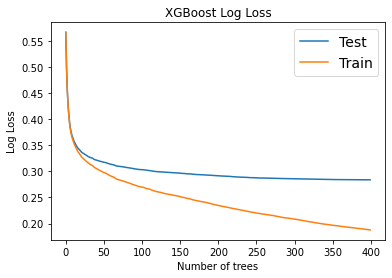

In [70]:
plt.plot(xgb_cv_2.index, xgb_cv_2['test-logloss-mean'], label='Test')
plt.plot(xgb_cv_2.index, xgb_cv_2['train-logloss-mean'], label='Train')
plt.xticks(np.arange(min(xgb_cv_2.index), max(xgb_cv_2.index)+1.1, 50)) 
plt.ylabel('Log Loss')
plt.xlabel('Number of trees')
plt.title('XGBoost Log Loss')
plt.legend(fontsize=14)
plt.show

In [71]:
iter_best_2 = len(xgb_cv_2)
iter_best_2 #400

400

In [72]:
clf_xgb_2 = xgb.XGBClassifier(n_estimators=iter_best_2, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
clf_xgb_2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [73]:
y_pred_2 = clf_xgb_2.predict(X_test)

confu_matrix_2 = confusion_matrix(y_test, y_pred_2)
(tn_2, fp_2, fn_2, tp_2) = confusion_matrix(y_test, y_pred_2).ravel()
accuracy_2 = accuracy_score(y_test, y_pred_2)
f1_score_2 = f1_score(y_test,y_pred_2)

print(confu_matrix_2,'\n')
print('tn:',tn_2, 'fp:',fp_2, 'fn:',fn_2, 'tp:',tp_2,'\n')
print('accuracy:',accuracy_2)
print('f1 score:',f1_score_2)

[[13718  1231]
 [ 1760  7071]] 

tn: 13718 fp: 1231 fn: 1760 tp: 7071 

accuracy: 0.8742220353238015
f1 score: 0.8254246191560148


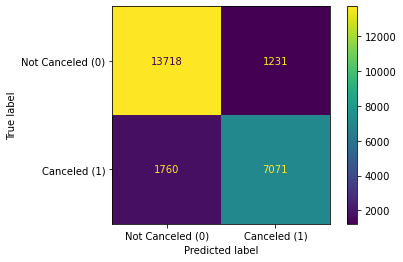

In [74]:
plot_confusion_matrix(clf_xgb_2, X_test, y_test, values_format='d', display_labels=['Not Canceled (0)','Canceled (1)'])

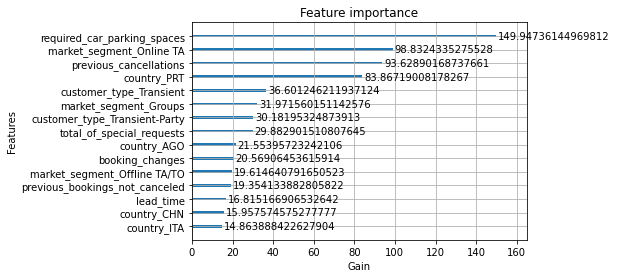

In [75]:
xgb.plot_importance(clf_xgb_2,max_num_features=15, importance_type = 'gain', xlabel='Gain')
plt.show()

In [76]:
# calculate how many variables to retain if you only want to keep the top 25 %  
len(dmatrix_2.feature_names)*0.25

81.0

In [77]:
# get the gain scores from clf_xgb_2, sort in descending order, and subset the top 25 %   
gain_score = clf_xgb_2.get_booster().get_score(importance_type='gain')
gain_score_df = pd.DataFrame.from_dict(gain_score, orient='index', columns = ['gain']).gain.sort_values(ascending=False)
features_keep = gain_score_df.iloc[:81]

In [78]:
# keep only variables with the top 25 % highest gain score 
X_train = X_train.loc[:,X_train.columns.isin(features_keep.index)]
X_test = X_test.loc[:,X_test.columns.isin(features_keep.index)]

In [79]:
# check that the new dmatrix3 only have 81 variables
dmatrix_3 = xgb.DMatrix(X_train, y_train)
len(dmatrix_3.feature_names)

81

In [80]:
xgb_cv_3 = xgb.cv(dtrain=dmatrix_3, params=params, nfold=5,
                    num_boost_round=500, early_stopping_rounds=10, verbose_eval=True, seed=RANDOM_STATE, shuffle=False)

[0]	train-logloss:0.56676+0.00058	test-logloss:0.56718+0.00126
[1]	train-logloss:0.49813+0.00096	test-logloss:0.49913+0.00205
[2]	train-logloss:0.45408+0.00082	test-logloss:0.45561+0.00271
[3]	train-logloss:0.42585+0.00140	test-logloss:0.42778+0.00240
[4]	train-logloss:0.40705+0.00138	test-logloss:0.40925+0.00302
[5]	train-logloss:0.39098+0.00175	test-logloss:0.39355+0.00344
[6]	train-logloss:0.38064+0.00170	test-logloss:0.38341+0.00363
[7]	train-logloss:0.37235+0.00185	test-logloss:0.37533+0.00355
[8]	train-logloss:0.36603+0.00179	test-logloss:0.36932+0.00304
[9]	train-logloss:0.36127+0.00189	test-logloss:0.36484+0.00330
[10]	train-logloss:0.35677+0.00182	test-logloss:0.36062+0.00349
[11]	train-logloss:0.35216+0.00200	test-logloss:0.35641+0.00377
[12]	train-logloss:0.34928+0.00206	test-logloss:0.35391+0.00376
[13]	train-logloss:0.34604+0.00173	test-logloss:0.35100+0.00371
[14]	train-logloss:0.34282+0.00168	test-logloss:0.34811+0.00364
[15]	train-logloss:0.33964+0.00162	test-logloss:0.

[128]	train-logloss:0.25307+0.00242	test-logloss:0.29619+0.00302
[129]	train-logloss:0.25260+0.00240	test-logloss:0.29597+0.00292
[130]	train-logloss:0.25207+0.00219	test-logloss:0.29579+0.00303
[131]	train-logloss:0.25169+0.00212	test-logloss:0.29567+0.00311
[132]	train-logloss:0.25138+0.00210	test-logloss:0.29564+0.00306
[133]	train-logloss:0.25117+0.00220	test-logloss:0.29554+0.00300
[134]	train-logloss:0.25081+0.00231	test-logloss:0.29537+0.00307
[135]	train-logloss:0.25056+0.00233	test-logloss:0.29530+0.00306
[136]	train-logloss:0.25021+0.00217	test-logloss:0.29519+0.00311
[137]	train-logloss:0.24989+0.00205	test-logloss:0.29517+0.00307
[138]	train-logloss:0.24941+0.00216	test-logloss:0.29498+0.00292
[139]	train-logloss:0.24914+0.00217	test-logloss:0.29494+0.00290
[140]	train-logloss:0.24884+0.00216	test-logloss:0.29489+0.00296
[141]	train-logloss:0.24857+0.00210	test-logloss:0.29484+0.00295
[142]	train-logloss:0.24834+0.00207	test-logloss:0.29477+0.00295
[143]	train-logloss:0.247

[255]	train-logloss:0.21323+0.00133	test-logloss:0.28753+0.00294
[256]	train-logloss:0.21301+0.00138	test-logloss:0.28752+0.00293
[257]	train-logloss:0.21276+0.00140	test-logloss:0.28745+0.00298
[258]	train-logloss:0.21242+0.00140	test-logloss:0.28729+0.00302
[259]	train-logloss:0.21202+0.00136	test-logloss:0.28720+0.00312
[260]	train-logloss:0.21178+0.00143	test-logloss:0.28721+0.00309
[261]	train-logloss:0.21158+0.00157	test-logloss:0.28720+0.00310
[262]	train-logloss:0.21142+0.00164	test-logloss:0.28716+0.00315
[263]	train-logloss:0.21119+0.00173	test-logloss:0.28713+0.00312
[264]	train-logloss:0.21095+0.00181	test-logloss:0.28711+0.00313
[265]	train-logloss:0.21057+0.00184	test-logloss:0.28702+0.00317
[266]	train-logloss:0.21039+0.00183	test-logloss:0.28702+0.00316
[267]	train-logloss:0.21023+0.00190	test-logloss:0.28701+0.00315
[268]	train-logloss:0.21000+0.00199	test-logloss:0.28701+0.00314
[269]	train-logloss:0.20978+0.00200	test-logloss:0.28702+0.00316
[270]	train-logloss:0.209

[382]	train-logloss:0.18544+0.00180	test-logloss:0.28507+0.00336
[383]	train-logloss:0.18529+0.00186	test-logloss:0.28505+0.00332
[384]	train-logloss:0.18508+0.00194	test-logloss:0.28503+0.00328
[385]	train-logloss:0.18477+0.00189	test-logloss:0.28499+0.00337
[386]	train-logloss:0.18454+0.00188	test-logloss:0.28495+0.00339
[387]	train-logloss:0.18440+0.00181	test-logloss:0.28491+0.00342
[388]	train-logloss:0.18428+0.00173	test-logloss:0.28489+0.00345
[389]	train-logloss:0.18413+0.00166	test-logloss:0.28487+0.00345
[390]	train-logloss:0.18400+0.00161	test-logloss:0.28485+0.00345
[391]	train-logloss:0.18383+0.00158	test-logloss:0.28482+0.00348
[392]	train-logloss:0.18368+0.00153	test-logloss:0.28483+0.00348
[393]	train-logloss:0.18350+0.00156	test-logloss:0.28485+0.00342
[394]	train-logloss:0.18323+0.00158	test-logloss:0.28488+0.00345
[395]	train-logloss:0.18301+0.00158	test-logloss:0.28485+0.00345
[396]	train-logloss:0.18280+0.00157	test-logloss:0.28480+0.00343
[397]	train-logloss:0.182

<function matplotlib.pyplot.show(close=None, block=None)>

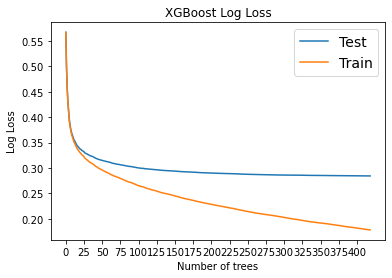

In [81]:
plt.plot(xgb_cv_3.index, xgb_cv_3['test-logloss-mean'], label='Test')
plt.plot(xgb_cv_3.index, xgb_cv_3['train-logloss-mean'], label='Train')
plt.xticks(np.arange(min(xgb_cv_3.index), max(xgb_cv_3.index)+1.1, 25)) 
plt.ylabel('Log Loss')
plt.xlabel('Number of trees')
plt.title('XGBoost Log Loss')
plt.legend(fontsize=14)
plt.show

In [82]:
iter_best_3 = len(xgb_cv_3)
iter_best_3 #419

419

In [83]:
clf_xgb_3 = xgb.XGBClassifier(n_estimators=iter_best_3, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
clf_xgb_3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=419, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [84]:
y_pred_3 = clf_xgb_3.predict(X_test)

confu_matrix_3 = confusion_matrix(y_test, y_pred_3)
(tn_3, fp_3, fn_3, tp_3) = confusion_matrix(y_test, y_pred_3).ravel()
accuracy_3 = accuracy_score(y_test, y_pred_3)
f1_score_3 = f1_score(y_test,y_pred_3)

print(confu_matrix_3,'\n')
print('tn:',tn_3, 'fp:',fp_3, 'fn:',fn_3, 'tp:',tp_3,'\n')
print('accuracy:',accuracy_3)
print('f1 score:',f1_score_3)

[[13690  1259]
 [ 1745  7086]] 

tn: 13690 fp: 1259 fn: 1745 tp: 7086 

accuracy: 0.8736753574432295
f1 score: 0.8251047973917093


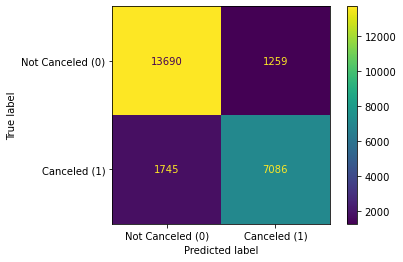

In [85]:
plot_confusion_matrix(clf_xgb_3, X_test, y_test, values_format='d', display_labels=['Not Canceled (0)','Canceled (1)'])

## 2.1. Hyperparamter tuning - Bayesian optimization

The model is now more sparse but so far we only used the default hyperparameter values for the XGBClassifier. One traditional way of performing hyperparameter optimization is grid search but that is not feasible in our case since the combination of hyperparameter values we can set is way too large for grid search to be an alternative. Another popular and less computational heavy approach is to set the hyperparameters randomly and see what parameter combinations yield the lowest log loss. An even better approach is to use Bayesian optimization instead of just randomly setting the hyperparameter values. Bayesian optimization calculates a mean and a variance of the log loss for a given combination of hyperparameter values and focuses it search around areas where the mean and variance gives the highest probability of finding a set of parameter values that decreases the log loss even further than the current lowest.
The steps for performing the hyperparameter tuning is roughly as follows:

(1) The Bayesian optimization optimizer needs a machine learning model as input, in our case an XGBoost model, thus start with creating the function XGbcv where the parameter values we are going to tune is defined. An XGBoost cross-validation model with the same num_boost_round as in iter_best_3 is also created in the function. From the cross-validation the iteration with the lowest ‘test-logloss-mean’ is returned and cast to a negative value since Bayesian optimization always seeks to maximize a function. This is necessary since in our case we want a low log loss.  

(2) XGbBO the Bayesian optimization optimizer is now created, the hyperparameter values are each set to a lower and upper bound. 25 initial randomised combinations of hyperparameter values are created so the optimizer is able to estimate the mean and variance in different areas in the 7-dimensional space (we tune seven variables). 275 iterations are then performed in regions where the combination of hyperparameter values with the best estimated probability of leading to the lowest log loss is chosen. 
To illustrate this the 300 iterations (25+275) is copied from the output and saved in a separate xlsx-file called ‘bayesian_optimization_iterations.xlsx’ where each current lowest log loss gets a purple row, similar to what happens in this notebook.  

(3) The hyperparameter values with the combined lowest log loss is stored in the list params_tuned 

(4) The standard procedure of training and validating of the XGBClassifieer is for a last time executed, this time with the optimal hyperparameter values. A comparison between clf_xgb_3 and clf_xgb_tuned is carried out.

Links:

Bayesian optimization documentation -
https://github.com/fmfn/BayesianOptimization 

### Alert
I have run the Bayesian optimization and assigned the optimised values to params_tuned. I put the code between quotation marks after that, because the Bayesian optimizer takes over 4 hours to run on a computer with:

* Processor: Intel® Core™ i5 10600k 4,8GHZ 
* Graphic card: Nvidia Geforce RTX2060 6GB (OC-version)
* RAM: 16GB DDR4 2666MHz 

I have created a copy of params_tuned so the rest of the project will still run smoothly and saved the output from the Bayesian optimizer in a separate xlsx file ‘bayesian_optimization_iterations.xlsx’ that you can download from my repository. 

If you want to test the Bayesian optimization anyway, remove the quotation marks and delete the cell containing the copy of params_tuned. 

In [86]:
def XGbcv(eta, lambda_bo, alpha, max_depth, gamma, min_child_weight, colsample_bytree):
    LOGLOSSbest = 1.
    ITERbest = 0

    paramt = {
              'booster' : 'gbtree',
              'objective': 'binary:logistic',
              'eval_metric': 'logloss',
              'seed' : RANDOM_STATE,
              'eta' : eta, # learning rate
              'lambda' : lambda_bo, # L2 regularization term 
              'alpha' : alpha, # L1 regularization term
              'max_depth' : max_depth.astype(int), # max depth of the trees
              'gamma' : gamma, # pruning of the trees
              'min_child_weight' : min_child_weight, # min number of observations in each leaf
              'colsample_bytree' : colsample_bytree # ratio of variables to choose from in each split
              }

    xgbc = xgb.cv(
           params = paramt,
           dtrain = dtrain,
           num_boost_round = iter_best_3,
           nfold = 5,
           verbose_eval = False,
           early_stopping_rounds = 10,
           seed=RANDOM_STATE,
           shuffle=False
          )

    cv_score = xgbc['test-logloss-mean'].iloc[-1]
    if ( cv_score < LOGLOSSbest ):
        LOGLOSSbest = cv_score
        ITERbest = len(xgbc)

    return (-1.0 * cv_score)

In [87]:
"""dtrain = xgb.DMatrix(X_train, y_train)

print("# Global Optimization Search for XGBoost Parameters")
print("\n Please note that negative Log Loss values will be shown below. This is because")
print(" Log Loss needs to be minimized, while the Bayesian Optimizer always maximizes the function.\n")

XGbBO = BayesianOptimization(XGbcv, {'max_depth': (8, 12),
                                     'gamma': (0.01, 0.6),
                                     'min_child_weight': (1, 6),
                                     'colsample_bytree' :(0.6, 1),
                                     'eta' :(0.1, 0.45),
                                     'lambda_bo': (0, 1),
                                     'alpha': (0.7, 1)}, 
                                     random_state = RANDOM_STATE)

XGbBO.maximize(init_points=25, n_iter=275, acq="ucb", kappa = 2.85, kappa_decay = 0.999, kappa_decay_delay = 50)
print("-" * 53)

best_LOGLOSS = round((-1.0 * XGbBO.max['target']), 6)
alpha = round(XGbBO.max['params']['alpha'], 6)
colsample_bytree = round(XGbBO.max['params']['colsample_bytree'], 6)
eta = round(XGbBO.max['params']['eta'], 6)
gamma = round(XGbBO.max['params']['gamma'], 6)
lambda_bo = round(XGbBO.max['params']['lambda_bo'], 6)
max_depth = round(XGbBO.max['params']['max_depth'])
min_child_weight = round(XGbBO.max['params']['min_child_weight'], 6)

print("\n Best Log Loss value: %f" % best_LOGLOSS)
print(" Best XGBoost parameters:")
print(" max_depth=%d, gamma=%f, min_child_weight=%f, colsample_bytree=%f, eta=%f, lambda_bo=%f, alpha=%f" % (int(max_depth), gamma, min_child_weight, colsample_bytree, eta, lambda_bo, alpha))"""

# Global Optimization Search for XGBoost Parameters

 Please note that negative Log Loss values will be shown below. This is because
 Log Loss needs to be minimized, while the Bayesian Optimizer always maximizes the function.

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | lambda_bo | max_depth | min_ch... |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.2842   |  0.8124   |  0.9803   |  0.3562   |  0.3632   |  0.156    |  8.624    |  1.29     |
|  2        | -0.2798   |  0.9599   |  0.8404   |  0.3478   |  0.02214  |  0.9699   |  11.33    |  2.062    |
|  3        | -0.2789   |  0.7545   |  0.6734   |  0.2065   |  0.3196   |  0.4319   |  9.165    |  4.059    |
|  4        | -0.2798   |  0.7418   |  0.7169   |  0.2282   |  0.2791   |  0.7852   |  8.799    |  3.571    |
|  5        | -0.2824   |  0.8777   |  0.6186   |  0.3126   |  0.1106   |  0.06505  |  11.8     |  5.828    |
|  

|  44       | -0.2741   |  0.7      |  0.6      |  0.1      |  0.6      |  0.09646  |  11.31    |  4.699    |
|  45       | -0.2745   |  0.7      |  0.6      |  0.1      |  0.2532   |  0.6243   |  11.68    |  4.595    |
|  46       | -0.2737   |  1.0      |  0.6      |  0.1      |  0.01066  |  0.0      |  11.54    |  4.403    |
|  47       | -0.2735   |  0.7      |  0.6      |  0.1      |  0.4955   |  0.0      |  11.99    |  4.157    |
|  48       | -0.2752   |  0.7      |  1.0      |  0.1      |  0.01     |  0.2619   |  11.96    |  4.044    |
|  49       | -0.2862   |  1.0      |  0.6      |  0.45     |  0.6      |  0.3558   |  11.71    |  4.204    |
|  50       | -0.2734   |  0.7      |  0.6      |  0.1      |  0.02797  |  0.0      |  12.0     |  4.608    |
|  51       | -0.2759   |  0.7      |  1.0      |  0.1      |  0.1071   |  0.0      |  11.54    |  4.608    |
|  52       | -0.2722   |  0.7      |  0.6      |  0.1      |  0.01     |  0.0      |  12.0     |  3.86     |
|  53     

|  89       | -0.2704   |  0.7      |  0.6      |  0.1      |  0.267    |  1.0      |  11.55    |  1.0      |
|  90       | -0.2765   |  1.0      |  0.6      |  0.1      |  0.01     |  0.0      |  10.26    |  6.0      |
|  91       | -0.2805   |  1.0      |  0.6      |  0.1      |  0.01     |  1.0      |  8.0      |  2.062    |
|  92       | -0.2718   |  0.7      |  0.6      |  0.1      |  0.6      |  0.5688   |  10.84    |  1.0      |
|  93       | -0.2708   |  0.7      |  0.6      |  0.1      |  0.01     |  1.0      |  11.67    |  1.466    |
|  94       | -0.2705   |  0.7      |  0.6      |  0.1      |  0.01     |  0.0      |  11.37    |  1.577    |
|  95       | -0.2719   |  1.0      |  0.6      |  0.1      |  0.01     |  1.0      |  12.0     |  3.006    |
|  96       | -0.2825   |  0.7      |  0.6      |  0.1      |  0.6      |  0.0      |  8.0      |  5.323    |
|  97       | -0.2703   |  0.7      |  0.6      |  0.1      |  0.3481   |  0.3036   |  12.0     |  1.882    |
|  98     

|  134      | -0.2719   |  1.0      |  0.6      |  0.1      |  0.6      |  0.0      |  10.87    |  1.0      |
|  135      | -0.2703   |  0.7      |  0.6      |  0.1      |  0.01     |  0.2992   |  12.0     |  1.212    |
|  136      | -0.271    |  1.0      |  0.6      |  0.1      |  0.6      |  0.435    |  12.0     |  2.02     |
|  137      | -0.2709   |  0.7      |  0.6      |  0.1      |  0.01     |  0.0      |  11.23    |  2.015    |
|  138      | -0.2715   |  1.0      |  0.6      |  0.1      |  0.01     |  0.0      |  10.11    |  1.0      |
|  139      | -0.2692   |  1.0      |  0.6      |  0.1      |  0.01     |  0.0      |  12.0     |  1.0      |
|  140      | -0.2739   |  0.7      |  0.6      |  0.1      |  0.01     |  0.4165   |  10.6     |  3.077    |
|  141      | -0.2721   |  1.0      |  0.6      |  0.1      |  0.01     |  0.8907   |  11.69    |  2.408    |
|  142      | -0.2699   |  0.7      |  0.6      |  0.1      |  0.01     |  1.0      |  12.0     |  1.885    |
|  143    

|  179      | -0.271    |  1.0      |  0.6      |  0.1      |  0.01     |  0.0      |  11.37    |  1.483    |
|  180      | -0.2738   |  1.0      |  0.6      |  0.1      |  0.01     |  1.0      |  11.29    |  4.253    |
|  181      | -0.2741   |  0.7      |  1.0      |  0.1      |  0.01     |  0.0      |  10.16    |  1.0      |
|  182      | -0.2699   |  0.7      |  0.6      |  0.1      |  0.01     |  0.6195   |  11.85    |  1.0      |
|  183      | -0.2702   |  0.7      |  0.6      |  0.1      |  0.6      |  0.0      |  11.32    |  1.0      |
|  184      | -0.2713   |  1.0      |  0.6      |  0.1      |  0.6      |  1.0      |  11.73    |  1.0      |
|  185      | -0.2704   |  0.7      |  0.6      |  0.1      |  0.01     |  0.8138   |  11.22    |  1.226    |
|  186      | -0.2687   |  0.7      |  0.6      |  0.1      |  0.01     |  0.4968   |  12.0     |  1.0      |
|  187      | -0.2764   |  0.7      |  0.6      |  0.1      |  0.6      |  0.0      |  10.85    |  5.397    |
|  188    

|  224      | -0.271    |  0.7      |  0.6      |  0.1      |  0.2246   |  0.7303   |  11.32    |  1.0      |
|  225      | -0.2709   |  0.8846   |  0.6      |  0.1      |  0.01     |  0.2952   |  11.22    |  1.0      |
|  226      | -0.2732   |  0.7      |  0.6      |  0.1      |  0.6      |  1.0      |  10.87    |  1.616    |
|  227      | -0.2706   |  0.7      |  0.6      |  0.1      |  0.6      |  0.4268   |  11.68    |  1.0      |
|  228      | -0.2724   |  0.7      |  0.6      |  0.1      |  0.6      |  0.5002   |  12.0     |  3.291    |
|  229      | -0.2727   |  1.0      |  0.6      |  0.1      |  0.01     |  1.0      |  10.77    |  1.37     |
|  230      | -0.2702   |  0.7      |  0.6      |  0.1      |  0.01     |  0.8426   |  12.0     |  1.702    |
|  231      | -0.2696   |  1.0      |  0.6      |  0.1      |  0.01     |  0.6402   |  12.0     |  1.0      |
|  232      | -0.2709   |  0.7      |  0.6      |  0.1      |  0.2428   |  0.0      |  11.44    |  1.272    |
|  233    

|  270      | -0.2721   |  0.7      |  0.6      |  0.1      |  0.01     |  0.0      |  10.68    |  2.193    |
|  271      | -0.2709   |  1.0      |  0.6      |  0.1      |  0.3115   |  0.7213   |  12.0     |  1.898    |
|  272      | -0.2719   |  1.0      |  0.6      |  0.1      |  0.01     |  0.0      |  10.99    |  1.798    |
|  273      | -0.2711   |  1.0      |  0.6      |  0.1      |  0.3943   |  0.0      |  12.0     |  2.454    |
|  274      | -0.2724   |  1.0      |  0.6      |  0.1      |  0.6      |  0.6676   |  11.0     |  1.0      |
|  275      | -0.2744   |  1.0      |  0.6      |  0.1      |  0.01     |  0.2941   |  9.804    |  1.313    |
|  276      | -0.2713   |  1.0      |  0.6      |  0.1      |  0.3289   |  0.4372   |  11.43    |  1.893    |
|  277      | -0.2747   |  0.7      |  1.0      |  0.1      |  0.01     |  0.0      |  11.09    |  2.013    |
|  278      | -0.2704   |  0.7      |  0.6      |  0.1      |  0.3354   |  0.6428   |  11.73    |  1.143    |
|  279    

In [88]:
# from the iteration with 'Best Log Loss value' set parameters to their optimal estimated values 
"""params_tuned = {
    'booster' : 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed' : RANDOM_STATE,
    'learning_rate' : eta,
    'reg_lambda' : lambda_bo,
    'reg_alpha' : alpha,
    'max_depth' : max_depth,
    'gamma' : gamma,
    'min_child_weight' : min_child_weight,
    'colsample_bytree' : colsample_bytree
    }

params_tuned"""

{'booster': 'gbtree',
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'seed': 42,
 'learning_rate': 0.1,
 'reg_lambda': 0.496769,
 'reg_alpha': 0.7,
 'max_depth': 12,
 'gamma': 0.01,
 'min_child_weight': 1.0,
 'colsample_bytree': 0.6}

In [89]:
# copy of params_tuned, use it when Bayesian optimization isn't used
params_tuned = {'booster': 'gbtree',
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'seed': RANDOM_STATE,
 'learning_rate': 0.1,
 'reg_lambda': 0.496769,
 'reg_alpha': 0.7,
 'max_depth': 12,
 'gamma': 0.01,
 'min_child_weight': 1.0,
 'colsample_bytree': 0.6}

In [90]:
dmatrix_tuned = xgb.DMatrix(X_train, y_train)

In [91]:
# params_tuned is set as parameter values in the cross-validation 
xgb_cv_tuned = xgb.cv(dtrain=dmatrix_tuned, params=params_tuned, nfold=5,
                    num_boost_round=500, early_stopping_rounds=10, verbose_eval=True, seed=RANDOM_STATE, shuffle=False)

[0]	train-logloss:0.65769+0.00022	test-logloss:0.65849+0.00038
[1]	train-logloss:0.61884+0.00397	test-logloss:0.62099+0.00345
[2]	train-logloss:0.58317+0.00388	test-logloss:0.58671+0.00418
[3]	train-logloss:0.55267+0.00336	test-logloss:0.55757+0.00521
[4]	train-logloss:0.53179+0.00542	test-logloss:0.53752+0.00618
[5]	train-logloss:0.50781+0.00625	test-logloss:0.51492+0.00746
[6]	train-logloss:0.48772+0.00780	test-logloss:0.49603+0.00741
[7]	train-logloss:0.46913+0.00628	test-logloss:0.47860+0.00663
[8]	train-logloss:0.45111+0.00793	test-logloss:0.46166+0.00814
[9]	train-logloss:0.43533+0.00655	test-logloss:0.44703+0.00658
[10]	train-logloss:0.42079+0.00604	test-logloss:0.43374+0.00689
[11]	train-logloss:0.40842+0.00686	test-logloss:0.42219+0.00727
[12]	train-logloss:0.39781+0.00789	test-logloss:0.41225+0.00774
[13]	train-logloss:0.38768+0.00903	test-logloss:0.40305+0.00863
[14]	train-logloss:0.37699+0.00802	test-logloss:0.39351+0.00889
[15]	train-logloss:0.36724+0.00823	test-logloss:0.

[128]	train-logloss:0.19266+0.00128	test-logloss:0.27575+0.00475
[129]	train-logloss:0.19200+0.00141	test-logloss:0.27560+0.00474
[130]	train-logloss:0.19142+0.00138	test-logloss:0.27549+0.00475
[131]	train-logloss:0.19096+0.00147	test-logloss:0.27537+0.00479
[132]	train-logloss:0.19066+0.00156	test-logloss:0.27534+0.00479
[133]	train-logloss:0.19000+0.00152	test-logloss:0.27524+0.00478
[134]	train-logloss:0.18958+0.00151	test-logloss:0.27514+0.00476
[135]	train-logloss:0.18905+0.00153	test-logloss:0.27506+0.00467
[136]	train-logloss:0.18837+0.00165	test-logloss:0.27492+0.00461
[137]	train-logloss:0.18788+0.00157	test-logloss:0.27485+0.00459
[138]	train-logloss:0.18753+0.00159	test-logloss:0.27482+0.00461
[139]	train-logloss:0.18707+0.00163	test-logloss:0.27472+0.00462
[140]	train-logloss:0.18661+0.00158	test-logloss:0.27463+0.00458
[141]	train-logloss:0.18592+0.00164	test-logloss:0.27456+0.00458
[142]	train-logloss:0.18539+0.00149	test-logloss:0.27445+0.00454
[143]	train-logloss:0.184

[255]	train-logloss:0.13959+0.00087	test-logloss:0.26897+0.00449
[256]	train-logloss:0.13919+0.00081	test-logloss:0.26893+0.00445
[257]	train-logloss:0.13889+0.00088	test-logloss:0.26891+0.00444
[258]	train-logloss:0.13844+0.00081	test-logloss:0.26887+0.00445
[259]	train-logloss:0.13809+0.00071	test-logloss:0.26884+0.00447
[260]	train-logloss:0.13763+0.00077	test-logloss:0.26883+0.00450
[261]	train-logloss:0.13737+0.00080	test-logloss:0.26883+0.00450
[262]	train-logloss:0.13698+0.00067	test-logloss:0.26881+0.00450
[263]	train-logloss:0.13671+0.00066	test-logloss:0.26881+0.00451
[264]	train-logloss:0.13624+0.00057	test-logloss:0.26873+0.00452
[265]	train-logloss:0.13594+0.00055	test-logloss:0.26875+0.00453
[266]	train-logloss:0.13562+0.00069	test-logloss:0.26876+0.00451
[267]	train-logloss:0.13520+0.00079	test-logloss:0.26875+0.00453
[268]	train-logloss:0.13476+0.00081	test-logloss:0.26874+0.00455
[269]	train-logloss:0.13438+0.00086	test-logloss:0.26878+0.00457
[270]	train-logloss:0.134

<function matplotlib.pyplot.show(close=None, block=None)>

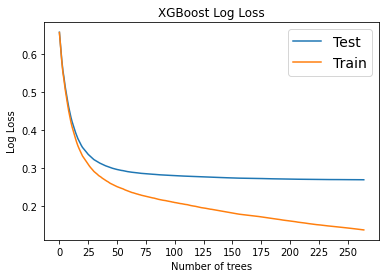

In [92]:
plt.plot(xgb_cv_tuned.index, xgb_cv_tuned['test-logloss-mean'], label='Test')
plt.plot(xgb_cv_tuned.index, xgb_cv_tuned['train-logloss-mean'], label='Train')
plt.xticks(np.arange(min(xgb_cv_tuned.index), max(xgb_cv_tuned.index)+1.1, 25)) 
plt.ylabel('Log Loss')
plt.xlabel('Number of trees')
plt.title('XGBoost Log Loss')
plt.legend(fontsize=14)
plt.show

In [93]:
iter_best_tuned = len(xgb_cv_tuned)
iter_best_tuned #265

265

In [94]:
# use the best iteration from xgb_cv_tuned and the parameters from params_tuned, then train the model. 
clf_xgb_tuned = xgb.XGBClassifier(n_estimators=iter_best_tuned, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', learning_rate=0.1, reg_lambda=0.496769, reg_alpha=0.7, max_depth=12, gamma=0.01, min_child_weight=1.0, colsample_bytree = 0.6)

clf_xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='logloss',
              gamma=0.01, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=12, min_child_weight=1.0, missing=nan,
              monotone_constraints='()', n_estimators=265, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0.7,
              reg_lambda=0.496769, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [95]:
y_pred_tuned = clf_xgb_tuned.predict(X_test)

confu_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
(tn_tuned, fp_tuned, fn_tuned, tp_tuned) = confusion_matrix(y_test, y_pred_tuned).ravel()
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
f1_score_tuned = f1_score(y_test,y_pred_tuned)

print(confu_matrix_tuned,'\n')
print('tn:',tn_tuned, 'fp:',fp_tuned, 'fn:',fn_tuned, 'tp:',tp_tuned,'\n')
print('accuracy:',accuracy_tuned)
print('f1 score:',f1_score_tuned)

[[13804  1145]
 [ 1629  7202]] 

tn: 13804 fp: 1145 fn: 1629 tp: 7202 

accuracy: 0.8833473507148865
f1 score: 0.8385143788566771


In [96]:
print(f'Accuracy clf_xgb_3:     {accuracy_3}')
print(f'Accuracy clf_xgb_tuned: {accuracy_tuned}')

Accuracy clf_xgb_3:     0.8736753574432295
Accuracy clf_xgb_tuned: 0.8833473507148865


In [97]:
print(f'F1 score clf_xgb_3:     {f1_score_3}')
print(f'F1 score clf_xgb_tuned: {f1_score_tuned}')

F1 score clf_xgb_3:     0.8251047973917093
F1 score clf_xgb_tuned: 0.8385143788566771


In [98]:
print(f'clf_xgb_3 confusion matrix\n{confu_matrix_3}\n')
print(f'clf_xgb_tuned confusion matrix\n{confu_matrix_tuned}')

clf_xgb_3 confusion matrix
[[13690  1259]
 [ 1745  7086]]

clf_xgb_tuned confusion matrix
[[13804  1145]
 [ 1629  7202]]


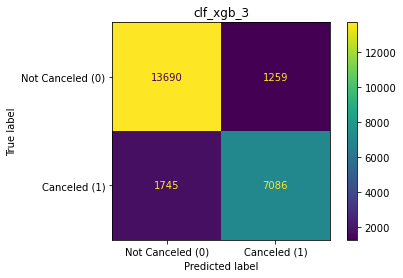

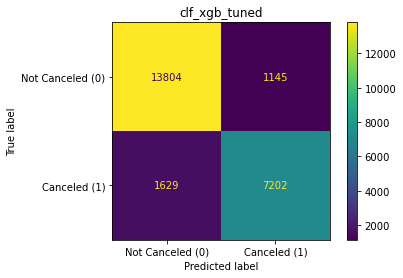

In [99]:
# plotted confusion matrix of the two classifiers clf_xgb_3 and clf_xgb_tuned
plot_confusion_matrix(clf_xgb_3, X_test, y_test, values_format='d', display_labels=['Not Canceled (0)','Canceled (1)'])
plt.title('clf_xgb_3')
plt.show()
plot_confusion_matrix(clf_xgb_tuned, X_test, y_test, values_format='d', display_labels=['Not Canceled (0)','Canceled (1)'])
plt.title('clf_xgb_tuned')
plt.show()

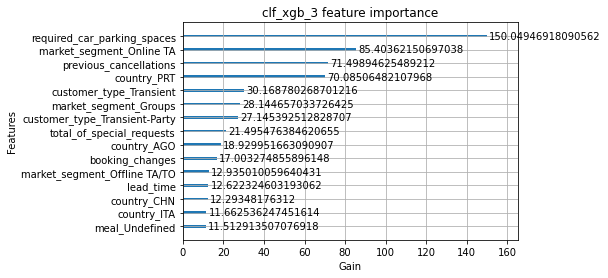

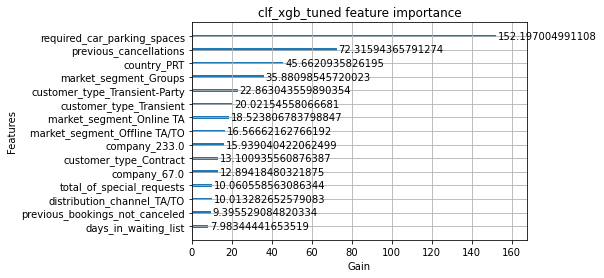

In [100]:
# feature importance plots of the two classifiers clf_xgb_3 and clf_xgb_tuned
xgb.plot_importance(clf_xgb_3,max_num_features=15, importance_type = 'gain', xlabel='Gain', title='clf_xgb_3 feature importance')
plt.show()
xgb.plot_importance(clf_xgb_tuned,max_num_features=15, importance_type = 'gain', xlabel='Gain', title='clf_xgb_tuned feature importance')
plt.show()

## 2.2. Evaluate the model 
Confusion matrix, accuracy and f1-scores are good but narrow ways to evaluate models. I’m now going to use other metrics to evaluate and widen our understanding of the model’s predictions. The steps for doing that is roughly as follows:

(1) ROC curve (receiver operating characteristic curve). The ROC curve is popular because it plots the performance of the model on all classification thresholds.  Lowering the classification threshold (let's say from the standard 50% to 30% for a positive 1) classifies more items as positive and increases both the false positives and the true positives. Thus the closer the line is to the top left corner the better because on those threshold values your classifier predicts many true positives and few false positives. The legend in the graph is the AUC-value, it’s simply the area under the ROC curve. The higher the AUC-value the more confident the model is at predicting 0 as 0 and 1 as 1. 

(2) The ROC curve shows the possible true positive and false positive rates that you can obtain on different cut off thresholds. But the ROC curve doesn’t specifically tell you what those threshold values are for the classifier. E.g. According to the ROC curve it’s possible to obtain a true positive rate of 0.8 and a false positive rate around 0.05, but the cut off threshold used to obtain these values is not specified. Thus a graph is constructed to tell which threshold leads to what true positive and false positive rate.        

(3) PDP (partial dependence plot) is a good tool to use when you want to visualize the effect different variable values have on the estimated probability of true (booking is cancelled). The creation of a PDP is straight forward, e.g. a dataset with several variables where one variable is ‘Sex’ with two unique values, Male and Female. First set all observations in ‘Sex’ to Male and keep all other variables in the data constant. Get the probabilities of 1, take the mean of those probabilities and plot it on the y-axis. Do the exact same procedure for Female and you're done. 
One constraint of the PDP is that you potentially can include some unreasonable observations. Say that your aim is to predict if you buy a house or not, and two of your variables are square metres and number of rooms. In the calculation of the mean probability it can happen that very obscure observations (square metres = 20 and number of rooms = 25) are included in the calculation.

### ROC

In [101]:
# create probabilities to use for AUC measures
y_pred_proba_tuned = clf_xgb_tuned.predict_proba(X_test)

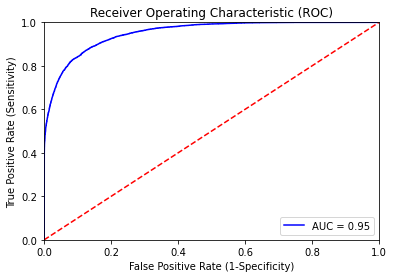

In [102]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba_tuned[:,1]) 
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.show()

In [103]:
def cut_off_threshold(y_true, y_proba):
    actual_0 = len(y_true[y_true == 0])
    actual_1 = len(y_true[y_true == 1])

    interval = np.linspace(0,1,11)
    interval_list_0 = np.repeat(0.0, 11)
    interval_list_1 = np.repeat(0.0, 11)

    for i in range(len(interval_list_0)):
        interval_list_0[i] = round(np.logical_and(y_true == 0, y_proba[:,0] <= interval[i]).sum() / actual_0, 4)
    for i in range(len(interval_list_1)):
        interval_list_1[i] = round(np.logical_and(y_true == 1, y_proba[:,1] < interval[i]).sum() / actual_1, 4)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout(pad=5)
    fig.suptitle('Cut Off Thresholds', fontsize=16)
    ax1.plot(interval,interval_list_0, 'm.-'), ax2.plot(interval,interval_list_1, 'c.-')

    number_ticks = np.arange(0, 1.0001, step=0.1)
    clean_ticks = np.arange(0, 1.0001, step=0.05)

    ax1.set(xlim = [0, 1], xticks=number_ticks, yticks=number_ticks,
    xlabel = "Maximum cut off value for setting prediction to 0", ylabel = 'False Positive Rate')
    ax2.set(xlim = [0, 1], xticks=number_ticks, yticks=number_ticks,
    xlabel = "Maximum cut off value for setting prediction to 1", ylabel = 'False Negative Rate')
    
    ax1.set_ylim(bottom=0, top=1), ax2.set_ylim(bottom=0, top=1)
    ax1.set_xticks(clean_ticks, minor=True), ax1.set_yticks(clean_ticks, minor=True)
    ax2.set_xticks(clean_ticks, minor=True), ax2.set_yticks(clean_ticks, minor=True)
    ax1.grid(which='minor', alpha=0.2), ax1.grid(which='major', alpha=0.5)
    ax2.grid(which='minor', alpha=0.2), ax2.grid(which='major', alpha=0.5)

    ax1_1 = ax1.twinx()
    ax2_1 = ax2.twinx()
    ax1_1.set_yticks(clean_ticks, minor=True),ax2_1.set_yticks(clean_ticks, minor=True)
    ax1_1.set_ylim(bottom=1, top=0),ax2_1.set_ylim(bottom=1, top=0)
    ax1_1.set(yticks=(np.arange(1.0, -0.1,-0.1)), ylabel = 'True Negative Rate')
    ax2_1.set(yticks=(np.arange(1.0, -0.1,-0.1)), ylabel = 'True Positive Rate')

    return plt.show()

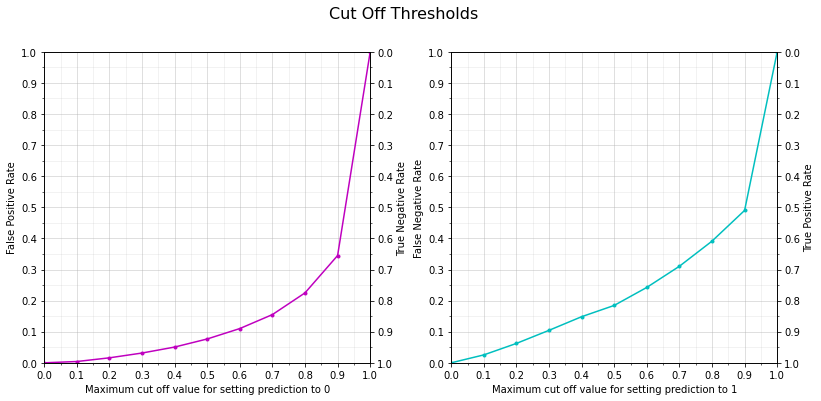

In [104]:
cut_off_threshold(y_test, y_pred_proba_tuned)

### Comment
The plot can be interpreted as follows: Let’s say you tolerate a true positive rate of minimum 0.9, the cut off value of the classifier for true (1) then is 0.3. This cut off value is chosen by looking at the value on the x axis on the right graph where the value on the true positive axis (right y axis) is 0.9. To verify that this is the correct threshold value let's look at the ROC curve where the true positive ratio is 0.9, we then see that the false positive value is around 0.15. We can verify that this threshold value is correct by observing that 1-0.3 (0.7) on the x-axis on the left graph equals the value 0.15 on the false positive axis (left y axis). 

The choice of which ratio to tolerate for the four different rates is purely a business decision. What rate that is most important to max or minimize varies between organizations and situations.

### PDP (partial dependence plot)

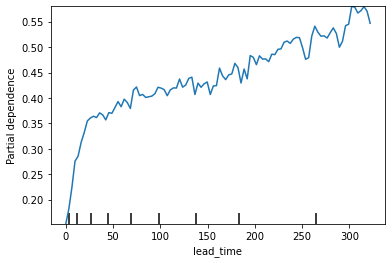

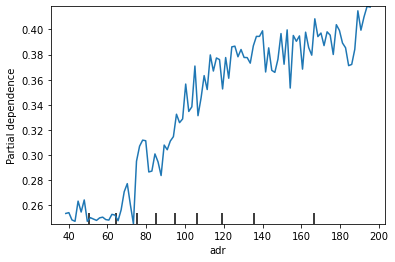

In [105]:
plot_partial_dependence(clf_xgb_tuned, X_test, ['lead_time'], response_method='predict_proba')
plt.show()
plot_partial_dependence(clf_xgb_tuned, X_test, ['adr'], response_method='predict_proba')
plt.show()

### Comment
The first plot shows that when the lead time of the booking is longer, the probability of a canceled booking increases. The second plot shows that if the average daily rate (adr) is higher then the probability of a canceled booking increases. 

# 3. Alibi
We have created a good classifier (AUC of 0.95) that can classify if a given person is going to cancel his/her booking or not. What if we could also estimate the minimum change needed on the variables to flip a observations binary prediction from 0 to 1 and vice versa? That is possible thanks to the Alibi python library. One method in the Albi library is ‘Counterfactuals Guided by Prototypes’, the method that is going to help us predict what change in variable values is needed to flip a prediction from cancel a booking to not cancel a booking and vice versa.
From a high level perspective, this is how the method works. 

(1) Choose an observation you want to inspect.

(2) An optimization process is executed with the goal of minimizing a loss by gradient descent. The loss term holds four parts that is minimized when:
The counterfactual flips the binary prediction.
The counterfactual variable values are as similar to the original variable values as possible.
The counterfactual variable values assumes similar values as observations in the original dataset with the same label. E.g. the counterfactual should not create a flip by setting an unreasonable variable value, like lead_time = 5000 (days). 
The distance between the counterfactual and the prototype is as short as possible (a prototype is created by grouping similar observations with the same label and calculating the mean values of that cluster).    

(3) If found, an counterfactual observation is presented. 

To be able to use the ‘Counterfactuals Guided by Prototypes’ method some minor data preparation is necessary: 

(A) All categorical values have been one-hot encoded prior to making our data more sparse by removing 75% of the variables. This is a problem because e.g. one observation could be encoded to come from Sweden, but if the variable Sweden is dropped this person has a zero in all encoded country variables. The solution to prevent this problem is to create an extra ‘_other’ variable.

(B) We need a way to measure the similarity between categorical variables, e.g. a bachelor’s degree is closer to a PhD degree than a high school degree is to a PhD.  

Links:

Alibi counterfactuals guided by prototypes documentation - 
https://docs.seldon.io/projects/alibi/en/stable/methods/CFProto.html  


### Comment
Solving the issue regarding some one-hot encoded variables missing its original values.

In [106]:
# subset categorical variables from X_train and X_test
X_train_objects = X_train.select_dtypes(include='uint8')
X_test_objects = X_test.select_dtypes(include='uint8') 
# subset numerical variables from X_train and X_test
X_train_numeric = X_train.drop(X_train_objects, axis=1)
X_test_numeric = X_test.drop(X_test_objects, axis=1)

In [107]:
# creating the 'other'-category
X_train_objects = X_train_objects.assign(hotel_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('hotel')].sum(axis=1))
X_train_objects = X_train_objects.assign(arrival_date_month_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('arrival_date_month')].sum(axis=1))
X_train_objects = X_train_objects.assign(country_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('country')].sum(axis=1))
X_train_objects = X_train_objects.assign(market_segment_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('market_segment')].sum(axis=1))
X_train_objects = X_train_objects.assign(distribution_channel_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('distribution_channel')].sum(axis=1))
X_train_objects = X_train_objects.assign(is_repeated_guest_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('is_repeated_guest')].sum(axis=1))
X_train_objects = X_train_objects.assign(reserved_room_type_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('reserved_room_type')].sum(axis=1))
X_train_objects = X_train_objects.assign(company_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('company')].sum(axis=1))
X_train_objects = X_train_objects.assign(customer_type_Other=X_train_objects.loc[:,X_train_objects.columns.str.startswith('customer_type')].sum(axis=1))

In [108]:
# the binary classification value in the '_Other' is the sum from the other variables in the same bracket and need to flip to be correctly set, e.g. arrival_date_month   
X_train_objects.loc[:,X_train_objects.columns.str.startswith('arrival_date_month')].head()

,arrival_date_month_August,arrival_date_month_February,arrival_date_month_July,arrival_date_month_June,arrival_date_month_May,arrival_date_month_October,arrival_date_month_September,arrival_date_month_Other
82795,0,0,0,0,0,0,0,0
78131,0,0,0,0,0,1,0,1
111080,0,0,0,0,1,0,0,1
67966,0,0,0,0,1,0,0,1
73536,1,0,0,0,0,0,0,1


In [109]:
X_train_objects.head()

,hotel_City Hotel,arrival_date_month_August,arrival_date_month_February,arrival_date_month_July,arrival_date_month_June,arrival_date_month_May,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,...,customer_type_Transient-Party,hotel_Other,arrival_date_month_Other,country_Other,market_segment_Other,distribution_channel_Other,is_repeated_guest_Other,reserved_room_type_Other,company_Other,customer_type_Other
82795,1,0,0,0,0,0,0,0,1,0,...,0,1,0,1,1,1,1,0,1,1
78131,1,0,0,0,0,0,1,0,1,0,...,1,1,1,1,1,1,1,0,1,1
111080,1,0,0,0,0,1,0,0,1,0,...,0,1,1,1,1,1,1,0,1,1
67966,1,0,0,0,0,1,0,0,1,0,...,0,1,1,1,1,1,1,0,1,1
73536,1,1,0,0,0,0,0,0,1,0,...,0,1,1,1,1,1,1,0,1,1


In [110]:
# function to flip the binary classification in the '_Other' variables, then sort and reindex the columns in the dataframe. 
def alibi_flip_Other_encoding(a):
    for i in a.columns:
        if i.endswith('_Other'):
            a[i] = np.where((a[i]==0)|(a[i]==1), a[i]^1, a[i])
            
    a = a.reindex(columns = sorted(a))
    return (a)

In [111]:
X_train_objects = alibi_flip_Other_encoding(X_train_objects)

In [112]:
# the '_Other' variables now have their correct binary value and the variables in X_train_objects is sorted, e.g. arrival_date_month 
X_train_objects.loc[:,X_train_objects.columns.str.startswith('arrival_date_month')].head()

,arrival_date_month_August,arrival_date_month_February,arrival_date_month_July,arrival_date_month_June,arrival_date_month_May,arrival_date_month_October,arrival_date_month_Other,arrival_date_month_September
82795,0,0,0,0,0,0,1,0
78131,0,0,0,0,0,1,0,0
111080,0,0,0,0,1,0,0,0
67966,0,0,0,0,1,0,0,0
73536,1,0,0,0,0,0,0,0


In [113]:
X_train_objects.head()

,arrival_date_month_August,arrival_date_month_February,arrival_date_month_July,arrival_date_month_June,arrival_date_month_May,arrival_date_month_October,arrival_date_month_Other,arrival_date_month_September,company_135.0,company_153.0,...,market_segment_Other,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_Other
82795,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
78131,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
111080,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
67966,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
73536,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [114]:
# the same procedure as for X_train_objects above is now done to X_test_objects
X_test_objects = X_test_objects.assign(hotel_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('hotel')].sum(axis=1))
X_test_objects = X_test_objects.assign(arrival_date_month_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('arrival_date_month')].sum(axis=1))
X_test_objects = X_test_objects.assign(country_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('country')].sum(axis=1))
X_test_objects = X_test_objects.assign(market_segment_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('market_segment')].sum(axis=1))
X_test_objects = X_test_objects.assign(distribution_channel_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('distribution_channel')].sum(axis=1))
X_test_objects = X_test_objects.assign(is_repeated_guest_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('is_repeated_guest')].sum(axis=1))
X_test_objects = X_test_objects.assign(reserved_room_type_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('reserved_room_type')].sum(axis=1))
X_test_objects = X_test_objects.assign(company_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('company')].sum(axis=1))
X_test_objects = X_test_objects.assign(customer_type_Other=X_test_objects.loc[:,X_test_objects.columns.str.startswith('customer_type')].sum(axis=1))

In [115]:
X_test_objects = alibi_flip_Other_encoding(X_test_objects)

In [116]:
# concatenate the categorical and numerical variables 
X_train_alibi_enc = pd.concat([X_train_objects, X_train_numeric], axis=1)
X_test_alibi_enc = pd.concat([X_test_objects, X_test_numeric], axis=1)
# matrix works best in alibi, reshape the data from dataframe to matrix 
X_train_alibi = np.asmatrix(X_train_alibi_enc)
X_test_alibi = np.asmatrix(X_test_alibi_enc)

In [117]:
# use the same parameters as in xgb_clf_tuned
clf_xgb_alibi = xgb.XGBClassifier(n_estimators=iter_best_tuned, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', learning_rate=0.1, reg_lambda=0.496769, reg_alpha=0.7, max_depth=12, gamma=0.01, min_child_weight=1.0, colsample_bytree = 0.6)

clf_xgb_alibi.fit(X_train_alibi, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='logloss',
              gamma=0.01, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=12, min_child_weight=1.0, missing=nan,
              monotone_constraints='()', n_estimators=265, n_jobs=12,
              num_parallel_tree=1, random_state=42, reg_alpha=0.7,
              reg_lambda=0.496769, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Comment
Indexing which one-hot encoded categories belongs to the same variable, to make it possible to measure the similarity between the categories in each variable.

In [118]:
cat_vars_ohe = {0: 8, 8: 11, 19: 30, 49: 4, 53: 5, 58: 2, 60: 2, 62: 6, 68: 5, 73: 4}

In [119]:
# set the range we allow the method to change it's variables to find counterfactuals  
# 0 and 1 for the categorical variables, the min and mean + 2 standard deviations from the X_test for the numeric variables   
feature_range = (np.array([([0.]*10) + X_test_alibi_enc.iloc[:,-13:].min().values.tolist()]),
    np.array([([1.]*10) + np.ceil(df.loc[:,X_test_alibi_enc.iloc[:,-13:].columns.values.tolist()].mean() + (2*df.loc[:,X_test_alibi_enc.iloc[:,-13:].columns.values.tolist()].std())).values.tolist()]))

In [120]:
feature_names = ['arrival_date_month','company','country','customer_type','distribution_channel','hotel','is_repeated_guest','market_segment','meal','reserved_room_type','lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'previous_cancellations','previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces','total_of_special_requests']

In [121]:
categorical_dict = {0: X_train_objects.loc[:,X_train_objects.columns.str.startswith('arrival_date_month')].columns.values.tolist(),
 1: X_train_objects.loc[:,X_train_objects.columns.str.startswith('company')].columns.values.tolist(),
 2: X_train_objects.loc[:,X_train_objects.columns.str.startswith('country')].columns.values.tolist(),
 3: X_train_objects.loc[:,X_train_objects.columns.str.startswith('customer_type')].columns.values.tolist(),
 4: X_train_objects.loc[:,X_train_objects.columns.str.startswith('distribution_channel')].columns.values.tolist(),
 5: X_train_objects.loc[:,X_train_objects.columns.str.startswith('hotel')].columns.values.tolist(),
 6: X_train_objects.loc[:,X_train_objects.columns.str.startswith('is_repeated_guest')].columns.values.tolist(),
 7: X_train_objects.loc[:,X_train_objects.columns.str.startswith('market_segment')].columns.values.tolist(),
 8: X_train_objects.loc[:,X_train_objects.columns.str.startswith('meal')].columns.values.tolist(),
 9: X_train_objects.loc[:,X_train_objects.columns.str.startswith('reserved_room_type')].columns.values.tolist()
 }

## 3.1. Counterfactuals Guided by Prototypes - in action

In [122]:
def describe_instance(X, explanation, eps=1e-2):
    print('Original instance: {}  -- proba: {}'.format(explanation.orig_class,
                                                       explanation.orig_proba[0]))
    print('Counterfactual instance: {}  -- proba: {}'.format(explanation.cf['class'],
                                                             explanation.cf['proba'][0]))
    print('\nCounterfactual perturbations...')
    print('\nCategorical:')
    X_orig_ord = ohe_to_ord(X, cat_vars_ohe)[0]
    X_cf_ord = ohe_to_ord(explanation.cf['X'], cat_vars_ohe)[0]
    delta_cat = {}
    for i, (_, v) in enumerate(categorical_dict.items()):
        cat_orig = v[int(X_orig_ord[0, i])]
        cat_cf = v[int(X_cf_ord[0, i])]
        if cat_orig != cat_cf:
            delta_cat[feature_names[i]] = [cat_orig, cat_cf]
    if delta_cat:
        for k, v in delta_cat.items():
            print('{}: {}  -->   {}'.format(k, v[0], v[1]))
    print('\nNumerical:')
    delta_num = X_cf_ord[0, -13:] - X_orig_ord[0, -13:]
    n_keys = len(list(cat_vars_ohe.keys()))
    for i in range(delta_num.shape[1]):
        if np.abs(delta_num[:,i]) > eps:
            print('{}: {:.2f}  -->   {:.2f}'.format(feature_names[i+n_keys],
                                            X_orig_ord[0,i+n_keys],
                                            X_cf_ord[0,i+n_keys]))

In [123]:
counterfactual_X_1 = 7431 # row number of the observation
counterfactual_X_2 = 2020

In [124]:
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

predict_fn = lambda x: clf_xgb_alibi.predict_proba(x)

cf = CounterFactualProto(predict_fn,
                         shape=(1, 90),
                         theta=10.,
                         kappa=0.,
                         beta=0.1,
                         cat_vars=cat_vars_ohe,
                         ohe=True,
                         use_kdtree=True,
                         max_iterations=500,
                         c_init=1,
                         c_steps=5,
                         feature_range=feature_range
                        )
cf.fit(X_train_alibi, trustscore_kwargs=None,  d_type='abdm', disc_perc=[25, 50, 75])
explanation = cf.explain(X_test_alibi[counterfactual_X_1].reshape((1,) + X_test_alibi[counterfactual_X_1].shape), k=2, verbose=False, print_every=100)
describe_instance(X_test_alibi[counterfactual_X_1], explanation)

Original instance: 1  -- proba: [0.46671182 0.5332882 ]
Counterfactual instance: 0  -- proba: [0.8029028  0.19709715]

Counterfactual perturbations...

Categorical:

Numerical:
total_of_special_requests: 0.00  -->   0.50


In [125]:
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

predict_fn = lambda x: clf_xgb_alibi.predict_proba(x)

cf = CounterFactualProto(predict_fn,
                         shape=(1, 90),
                         theta=10.,
                         kappa=0.,
                         beta=0.1,
                         cat_vars=cat_vars_ohe,
                         ohe=True,
                         use_kdtree=True,
                         max_iterations=500,
                         c_init=1,
                         c_steps=5,
                         feature_range=feature_range
                        )
cf.fit(X_train_alibi, trustscore_kwargs=None,  d_type='abdm', disc_perc=[25, 50, 75])
explanation = cf.explain(X_test_alibi[counterfactual_X_2].reshape((1,) + X_test_alibi[counterfactual_X_2].shape), k=2, verbose=False, print_every=100)
describe_instance(X_test_alibi[counterfactual_X_2], explanation)

Original instance: 1  -- proba: [0.4543084 0.5456916]
Counterfactual instance: 0  -- proba: [0.9058957  0.09410426]

Counterfactual perturbations...

Categorical:
market_segment: market_segment_Online TA  -->   market_segment_Direct

Numerical:


### Comment
The examples are two predictions classified to 1 (booking is cancelled). The counterfactuals guided by prototypes method then predict what minimal change to the variables is required to flip the prediction from 1 to 0 (not canceled). In this case if the number of special requests goes from zero to one (rounded to closest integer) for the first example, and if the booking is made directly via the hotel instead through an online travel agent for the second example. The original probabilities and the counterfactual probabilities for 1 and 0 is also displayed. 